# CellOracle GRN Calculation - Per Cell Type
Loop through each cell type in `cluster_annot`, subset data, and build GRNs using `sample` as the cluster unit.

## 0. Import libraries

In [12]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

import celloracle as co
co.__version__

'0.20.0'

In [13]:
# Visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

## 1. Load full dataset and base GRN

In [14]:
# Load full data
adata_full = sc.read_h5ad("CTR9_snRNASeq/CTR9_snRNASeq_full.h5ad")
print(f"Loaded data: {adata_full.shape[0]} cells x {adata_full.shape[1]} genes")
print(f"\nCell types (cluster_annot): {adata_full.obs['cluster_annot'].unique().tolist()}")
print(f"Samples: {adata_full.obs['sample'].unique().tolist()}")
adata_full

Loaded data: 9869 cells x 33696 genes

Cell types (cluster_annot): ['Epi_Kit+Elf5+', 'Epi_Ctr9+', 'Bcells', 'Pericytes/SMC', 'BasalEpi_Acta2+Trp63', 'Adipocyte', 'Endothelials', 'Fibroblasts', 'Tcells', 'DCs', 'Myeloid_cells', 'Schwann?', 'Epi_proliferating', 'SMC?']
Samples: ['WT_DM', 'KO_DM']


AnnData object with n_obs × n_vars = 9869 × 33696
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.1', 'RNA_snn_res.1', 'RNA_snn_res.0.2', 'cluster_annot'

In [15]:
# Load base GRN once (shared across all cell types)
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()
print(f"Base GRN shape: {base_GRN.shape}")
base_GRN.head()

Base GRN shape: (91976, 1095)


peak_id gene_short_name  9430076c15rik  Ac002126.6  \
0  chr10_100050979_100052296   4930430F08Rik            0.0         0.0   
1  chr10_101006922_101007748         SNORA17            0.0         0.0   
2  chr10_101144061_101145000          Mgat4c            0.0         0.0   
3    chr10_10148873_10149183   9130014G24Rik            0.0         0.0   
4    chr10_10149425_10149815   9130014G24Rik            0.0         0.0   

   Ac012531.1  Ac226150.2  Afp  Ahr  Ahrr  Aire  ...  Znf784  Znf8  Znf816  \
0         1.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
1         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
2         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
3         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
4         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   

   Znf85  Zscan10  Zscan16  Zscan22  Zscan26  Zscan31  Zscan4  
0    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
1    0.0      0.0      0.0      0.0      0.0      1.0     0.0  
2    0.0      0.0      0.0      0.0      0.0      0.0     1.0  
3    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
4    0.0      0.0      0.0      0.0      0.0      0.0     0.0  

[5 rows x 1095 columns]

In [16]:
# Get all cell types
cell_types = adata_full.obs['cluster_annot'].unique().tolist()
print(f"Will process {len(cell_types)} cell types:")
for i, ct in enumerate(cell_types):
    n_cells = (adata_full.obs['cluster_annot'] == ct).sum()
    print(f"  {i}: {ct} ({n_cells} cells)")

Will process 14 cell types:
  0: Epi_Kit+Elf5+ (1811 cells)
  1: Epi_Ctr9+ (943 cells)
  2: Bcells (519 cells)
  3: Pericytes/SMC (142 cells)
  4: BasalEpi_Acta2+Trp63 (1066 cells)
  5: Adipocyte (1802 cells)
  6: Endothelials (442 cells)
  7: Fibroblasts (908 cells)
  8: Tcells (1333 cells)
  9: DCs (162 cells)
  10: Myeloid_cells (404 cells)
  11: Schwann? (37 cells)
  12: Epi_proliferating (221 cells)
  13: SMC? (79 cells)


## 2. Create output directories

In [17]:
# Base output directories
base_results = "celloracle_results/per_celltype"
base_figures = "celltype_figures"
base_genes = "celltype_genes"

os.makedirs(base_results, exist_ok=True)
os.makedirs(base_figures, exist_ok=True)
os.makedirs(base_genes, exist_ok=True)
print("\u2713 Base directories created")

✓ Base directories created


## 3. Define the per-cell-type pipeline function

In [18]:
def run_celloracle_for_celltype(adata_full, cell_type, base_GRN,
                                 base_results, base_figures, base_genes,
                                 min_cells=50, n_top_genes=3000):
    """
    Run the full CellOracle pipeline for a single cell type.
    GRN is built using 'sample' as the cluster unit (WT vs KO comparison).
    
    Parameters
    ----------
    adata_full : AnnData
        Full dataset
    cell_type : str
        Cell type to subset from cluster_annot
    base_GRN : pd.DataFrame
        Base GRN from CellOracle
    min_cells : int
        Minimum number of cells required to run pipeline
    n_top_genes : int
        Number of highly variable genes to select
    """
    # Safe name for file paths
    safe_name = cell_type.replace("/", "_").replace("\\", "_").replace(" ", "_")
    
    # Create cell-type-specific directories
    save_folder = f"{base_figures}/{safe_name}"
    os.makedirs(save_folder, exist_ok=True)
    os.makedirs(f"{save_folder}/degree_distribution", exist_ok=True)
    os.makedirs(f"{save_folder}/ranked_score", exist_ok=True)
    os.makedirs(f"{save_folder}/score_comparison", exist_ok=True)
    os.makedirs(f"{save_folder}/top30_degree_centrality", exist_ok=True)
    os.makedirs(f"{base_genes}/{safe_name}", exist_ok=True)
    
    print(f"\n{'='*70}")
    print(f"  Processing: {cell_type}")
    print(f"{'='*70}")
    
    # =========================================================
    # 1. Subset to this cell type
    # =========================================================
    adata = adata_full[adata_full.obs['cluster_annot'] == cell_type, :].copy()
    print(f"\n[1] Subset: {adata.shape[0]} cells x {adata.shape[1]} genes")
    
    # Check minimum cell count
    if adata.shape[0] < min_cells:
        print(f"  ⚠ Skipping {cell_type}: only {adata.shape[0]} cells (min={min_cells})")
        return None, None
    
    # Check sample distribution
    sample_counts = adata.obs['sample'].value_counts()
    print(f"  Sample distribution:")
    for s, c in sample_counts.items():
        print(f"    {s}: {c} cells")
    
    if len(sample_counts) < 2:
        print(f"  ⚠ Skipping {cell_type}: only 1 sample present")
        return None, None
    
    # =========================================================
    # 2. Preprocessing
    # =========================================================
    print(f"\n[2] Preprocessing...")
    
    # Save raw counts to layers
    if hasattr(adata, 'raw') and adata.raw is not None:
        adata.layers['counts'] = adata.raw.X.copy()
        adata.layers['log1p'] = adata.X.copy()
    else:
        adata.layers['counts'] = adata.X.copy()
    
    # Filter genes
    sc.pp.filter_genes(adata, min_counts=1)
    print(f"  After gene filtering: {adata.shape}")
    
    # Normalize
    sc.pp.normalize_total(adata, target_sum=1e4)
    
    # Select HVGs - adjust n_top_genes if we have fewer genes
    actual_n_top = min(n_top_genes, adata.shape[1] - 1)
    filter_result = sc.pp.filter_genes_dispersion(
        adata.X,
        flavor='cell_ranger',
        n_top_genes=actual_n_top,
        log=False
    )
    print(f"  Selected {filter_result.gene_subset.sum()} highly variable genes")
    
    adata = adata[:, filter_result.gene_subset]
    
    # Renormalize
    sc.pp.normalize_total(adata, target_sum=1e4)
    print(f"  After HVG selection: {adata.shape}")
    
    # =========================================================
    # 3. Compute embeddings
    # =========================================================
    print(f"\n[3] Computing embeddings...")
    
    if 'X_pca' not in adata.obsm.keys():
        sc.pp.pca(adata, n_comps=min(50, adata.shape[0] - 1, adata.shape[1] - 1))
    print(f"  \u2713 PCA")
    
    n_neighbors = min(30, adata.shape[0] - 1)
    sc.pp.neighbors(adata, n_pcs=min(30, adata.obsm['X_pca'].shape[1]), n_neighbors=n_neighbors)
    print(f"  \u2713 Neighbors (n={n_neighbors})")
    
    sc.tl.umap(adata)
    print(f"  \u2713 UMAP")
    
    # Save UMAP plot
    sc.pl.umap(adata, color='sample', title=f"{cell_type} - by sample", show=False)
    plt.savefig(f"{save_folder}/umap_by_sample.png", dpi=150, bbox_inches='tight')
    plt.close()
    
    # =========================================================
    # 4. Create Oracle object
    # =========================================================
    print(f"\n[4] Creating Oracle object...")
    
    oracle = co.Oracle()
    
    # Import data - use 'sample' as cluster column for WT vs KO GRN building
    oracle.import_anndata_as_raw_count(
        adata=adata,
        cluster_column_name="sample",
        embedding_name="X_umap"
    )
    print(f"  \u2713 Data imported (cluster_column='sample')")
    
    # Import TF info
    oracle.import_TF_data(TF_info_matrix=base_GRN)
    print(f"  \u2713 TF data imported")
    
    # =========================================================
    # 5. KNN imputation
    # =========================================================
    print(f"\n[5] KNN imputation...")
    
    oracle.perform_PCA()
    
    # Select n_comps
    try:
        n_comps = np.where(
            np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_)) > 0.002)
        )[0][0]
    except IndexError:
        n_comps = min(20, oracle.adata.shape[0] - 1)
    n_comps = max(n_comps, 5)  # Ensure at least 5 components
    print(f"  PCA components: {n_comps}")
    
    n_cell = oracle.adata.shape[0]
    k = max(int(0.025 * n_cell), 5)  # Ensure k >= 5
    print(f"  Cell count: {n_cell}, k: {k}")
    
    oracle.knn_imputation(
        n_pca_dims=n_comps,
        k=k,
        balanced=True,
        b_sight=k * 8,
        b_maxl=k * 4,
        n_jobs=4
    )
    print(f"  \u2713 KNN imputation complete")
    
    # Save oracle object
    oracle_path = f"{base_results}/{safe_name}.celloracle.oracle"
    oracle.to_hdf5(oracle_path)
    print(f"  \u2713 Oracle saved: {oracle_path}")
    
    # =========================================================
    # 6. GRN calculation (using 'sample' as cluster unit)
    # =========================================================
    print(f"\n[6] GRN calculation (by sample)...")
    
    links = oracle.get_links(
        cluster_name_for_GRN_unit="sample",
        alpha=10,
        verbose_level=10
    )
    
    # Save raw links
    links_path = f"{base_results}/{safe_name}.celloracle.links"
    links.to_hdf5(file_path=links_path)
    print(f"  \u2713 Links saved: {links_path}")
    
    # =========================================================
    # 7. Network preprocessing
    # =========================================================
    print(f"\n[7] Network preprocessing...")
    
    links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)
    print(f"  \u2713 Links filtered")
    
    # Degree distribution plots
    for cluster in links.cluster:
        safe_cluster = cluster.replace("/", "_").replace("\\", "_")
        cluster_folder = f"{save_folder}/degree_distribution/degree_dist_{safe_cluster}"
        os.makedirs(cluster_folder, exist_ok=True)
    
    plt.rcParams["figure.figsize"] = [9, 4.5]
    links.plot_degree_distributions(
        plot_model=True,
        save=f"{save_folder}/degree_distribution/"
    )
    plt.rcParams["figure.figsize"] = [6, 4.5]
    
    # =========================================================
    # 8. Network scores
    # =========================================================
    print(f"\n[8] Calculating network scores...")
    
    links.get_network_score()
    print(f"  \u2713 Network scores calculated")
    
    # Save filtered + scored links
    filtered_links_path = f"{base_results}/{safe_name}_filtered.celloracle.links"
    links.to_hdf5(file_path=filtered_links_path)
    print(f"  \u2713 Filtered links saved: {filtered_links_path}")
    
    # =========================================================
    # 9. Save gene scores
    # =========================================================
    print(f"\n[9] Saving gene scores...")
    
    merged_scores = links.merged_score
    for clust in links.cluster:
        safe_cluster = clust.replace("/", "_").replace("\\", "_")
        filepath = f"{base_genes}/{safe_name}/{safe_cluster}_all_genes.csv"
        scores = merged_scores.loc[merged_scores['cluster'] == clust]
        scores_sorted = scores.sort_values('degree_centrality_all', ascending=False)
        scores_sorted.to_csv(filepath)
        print(f"  \u2713 Saved: {filepath}")
    
    # =========================================================
    # 10. Visualize top genes with high degree centrality
    # =========================================================
    print(f"\n[10] Visualizing top genes...")
    
    all_top_genes = []
    for sample_name in links.cluster:
        df = links.merged_score[links.merged_score["cluster"] == sample_name].copy()
        df_sorted = df.sort_values("degree_centrality_all", ascending=False).head(50)
        
        # Collect top genes
        df_top = df_sorted[["degree_centrality_all"]].copy()
        df_top["sample"] = sample_name
        df_top["cell_type"] = cell_type
        df_top["gene"] = df_top.index
        df_top["rank"] = range(1, len(df_top) + 1)
        all_top_genes.append(df_top)
        
        # Plot top 30
        df_plot = df_sorted.head(30)
        fig, ax = plt.subplots(figsize=(6, 8))
        ax.scatter(df_plot["degree_centrality_all"].values, range(len(df_plot)))
        ax.set_yticks(range(len(df_plot)))
        ax.set_yticklabels(df_plot.index)
        ax.invert_yaxis()
        ax.set_xlabel("degree_centrality_all")
        ax.set_title(f"degree_centrality_all\ntop 30 in {cell_type} - {sample_name}")
        plt.tight_layout()
        safe_sample = sample_name.replace("/", "_")
        plt.savefig(f"{save_folder}/top30_degree_centrality/{safe_sample}.png", dpi=150)
        plt.close()
    
    # Save combined CSV
    if all_top_genes:
        combined_df = pd.concat(all_top_genes, ignore_index=True)
        combined_df = combined_df[["cell_type", "sample", "rank", "gene", "degree_centrality_all"]]
        combined_df.to_csv(f"{save_folder}/top50_degree_centrality_by_sample.csv", index=False)
        print(f"  \u2713 Top genes CSV saved")
    
    # =========================================================
    # 11. Heatmap of network scores
    # =========================================================
    print(f"\n[11] Creating heatmap...")
    
    N_GENES_HEATMAP = 50
    top_genes = set()
    for cluster in links.cluster:
        cluster_mask = links.merged_score['cluster'] == cluster
        cluster_scores = links.merged_score.loc[
            cluster_mask, 'degree_centrality_all'
        ].sort_values(ascending=False)
        top_genes.update(cluster_scores.head(N_GENES_HEATMAP).index)
    
    score_df = links.merged_score[['cluster', 'degree_centrality_all']].copy()
    score_df = score_df[score_df.index.isin(top_genes)]
    pivot_table = score_df.pivot(columns='cluster', values='degree_centrality_all')
    
    plt.figure(figsize=(10, 16))
    sns.heatmap(pivot_table, cmap='viridis',
                cbar_kws={'label': 'Degree Centrality'},
                linewidths=0.5, linecolor='gray')
    plt.title(f'Network Degree Centrality - {cell_type}\nTop {N_GENES_HEATMAP} Genes per Sample',
              fontsize=14, fontweight='bold')
    plt.xlabel('Sample', fontsize=12)
    plt.ylabel('Gene', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f"{save_folder}/network_score_heatmap.png", dpi=300, bbox_inches='tight')
    plt.close()
    print(f"  \u2713 Heatmap saved")
    
    # =========================================================
    # 12. Score comparison between samples (WT vs KO)
    # =========================================================
    print(f"\n[12] Score comparison between samples...")
    
    if len(links.cluster) >= 2:
        CLUSTER1 = links.cluster[0]
        CLUSTER2 = links.cluster[1]
        print(f"  Comparing: {CLUSTER1} vs {CLUSTER2}")
        
        # --- Symmetrical-axis version of plot_score_comparison_2D ---
        res = links.merged_score[links.merged_score.cluster.isin([CLUSTER1, CLUSTER2])][["degree_centrality_all", "cluster"]]
        res = res.reset_index(drop=False)
        piv = pd.pivot_table(res, values="degree_centrality_all", columns="cluster", index="index")
        piv = piv.fillna(0)
        
        goi1 = piv[piv[CLUSTER1] > np.percentile(piv[CLUSTER1].values, 97)].index
        goi2 = piv[piv[CLUSTER2] > np.percentile(piv[CLUSTER2].values, 97)].index
        gois = np.union1d(goi1, goi2)
        
        x, y = piv[CLUSTER1], piv[CLUSTER2]
        plt.scatter(x, y, c="none", edgecolor="black")
        
        x_shift = (x.max() - x.min()) * 0.03
        y_shift = (y.max() - y.min()) * 0.03
        for goi in gois:
            gx, gy = piv.loc[goi, CLUSTER1], piv.loc[goi, CLUSTER2]
            plt.scatter(gx, gy, c="none", edgecolor="red")
            plt.text(gx + x_shift, gy + y_shift, goi, fontsize=6)
        
        # Set symmetrical axes
        max_val = max(x.max(), y.max()) * 1.05
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        ax = plt.gca()
        ax.set_aspect("equal")
        
        plt.xlabel(CLUSTER1)
        plt.ylabel(CLUSTER2)
        plt.title("degree_centrality_all")
        
        comp_path = os.path.join(f"{save_folder}/score_comparison",
            f"values_comparison_in_{links.name}_degree_centrality_all_{links.threshold_number}_{CLUSTER1}_vs_{CLUSTER2}.png")
        plt.savefig(comp_path, transparent=True)
        plt.show()
        plt.close()
        print(f"  ✓ Comparison plot saved (symmetrical axes)")
    else:
        print(f"  ⚠ Only {len(links.cluster)} sample(s) - skipping comparison")
    
    print(f"\n{'='*70}")
    print(f"  ✓ COMPLETED: {cell_type}")
    print(f"{'='*70}\n")
    
    return oracle, links

## 4. Run pipeline for all cell types



>>> [1/14] Starting: Epi_Kit+Elf5+

  Processing: Epi_Kit+Elf5+

[1] Subset: 1811 cells x 33696 genes
  Sample distribution:
    WT_DM: 935 cells
    KO_DM: 876 cells

[2] Preprocessing...
  After gene filtering: (1811, 21729)
  Selected 3000 highly variable genes
  After HVG selection: (1811, 3000)

[3] Computing embeddings...
  ✓ PCA
  ✓ Neighbors (n=30)
  ✓ UMAP

[4] Creating Oracle object...
  ✓ Data imported (cluster_column='sample')
  ✓ TF data imported

[5] KNN imputation...
  PCA components: 99
  Cell count: 1811, k: 45
  ✓ KNN imputation complete
  ✓ Oracle saved: celloracle_results/per_celltype/Epi_Kit+Elf5+.celloracle.oracle

[6] GRN calculation (by sample)...


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for KO_DM...


  0%|          | 0/2039 [00:00<?, ?it/s]

Inferring GRN for WT_DM...


  0%|          | 0/2039 [00:00<?, ?it/s]

  ✓ Links saved: celloracle_results/per_celltype/Epi_Kit+Elf5+.celloracle.links

[7] Network preprocessing...
  ✓ Links filtered
KO_DM


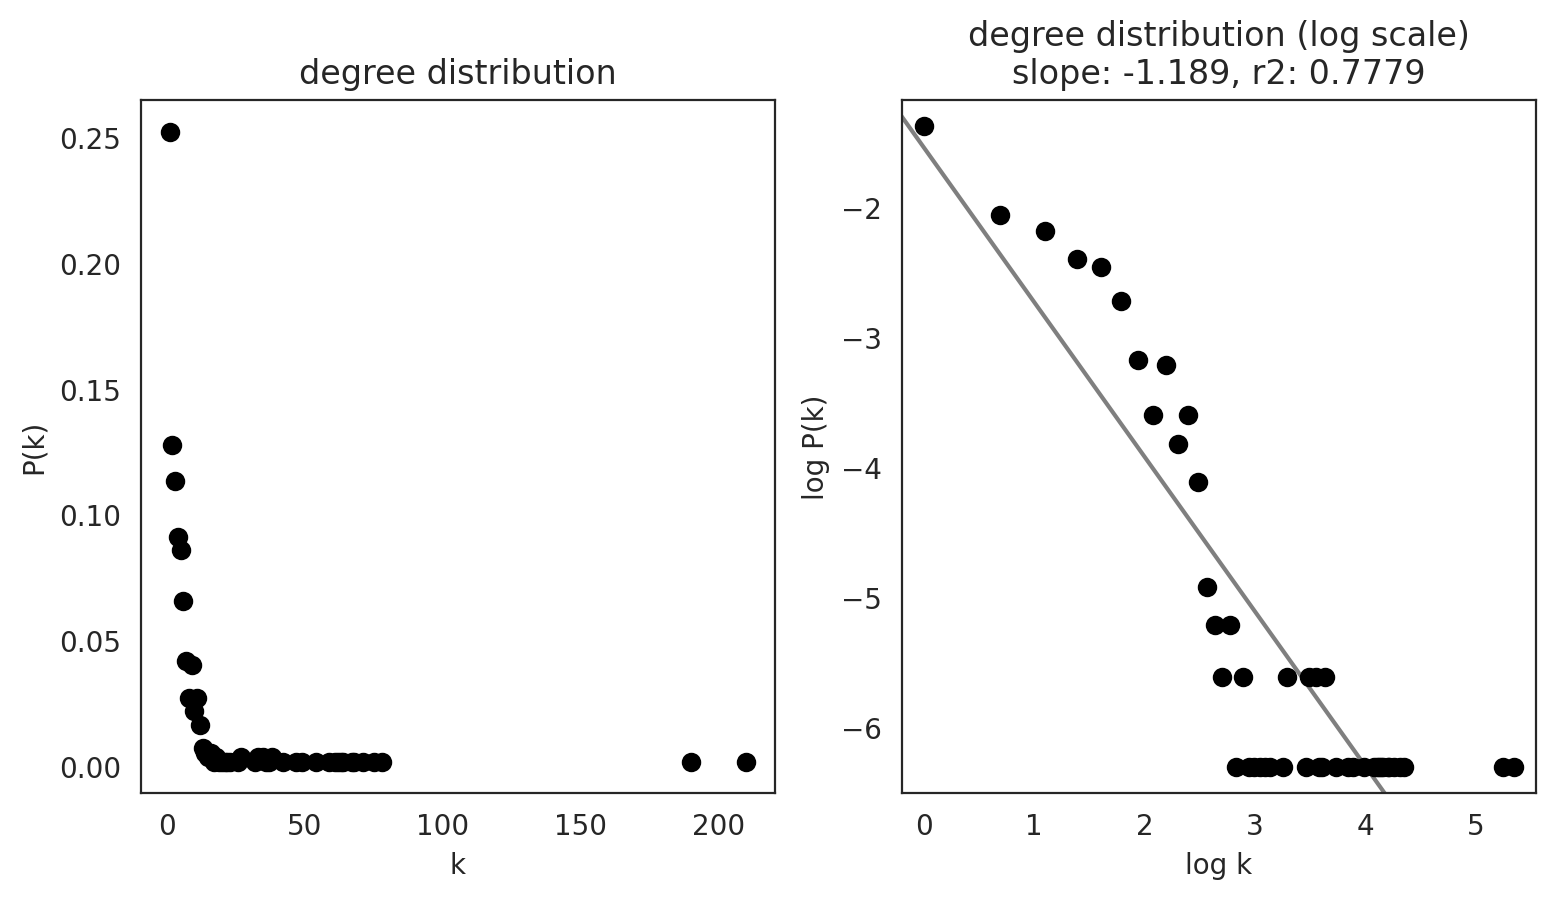

WT_DM


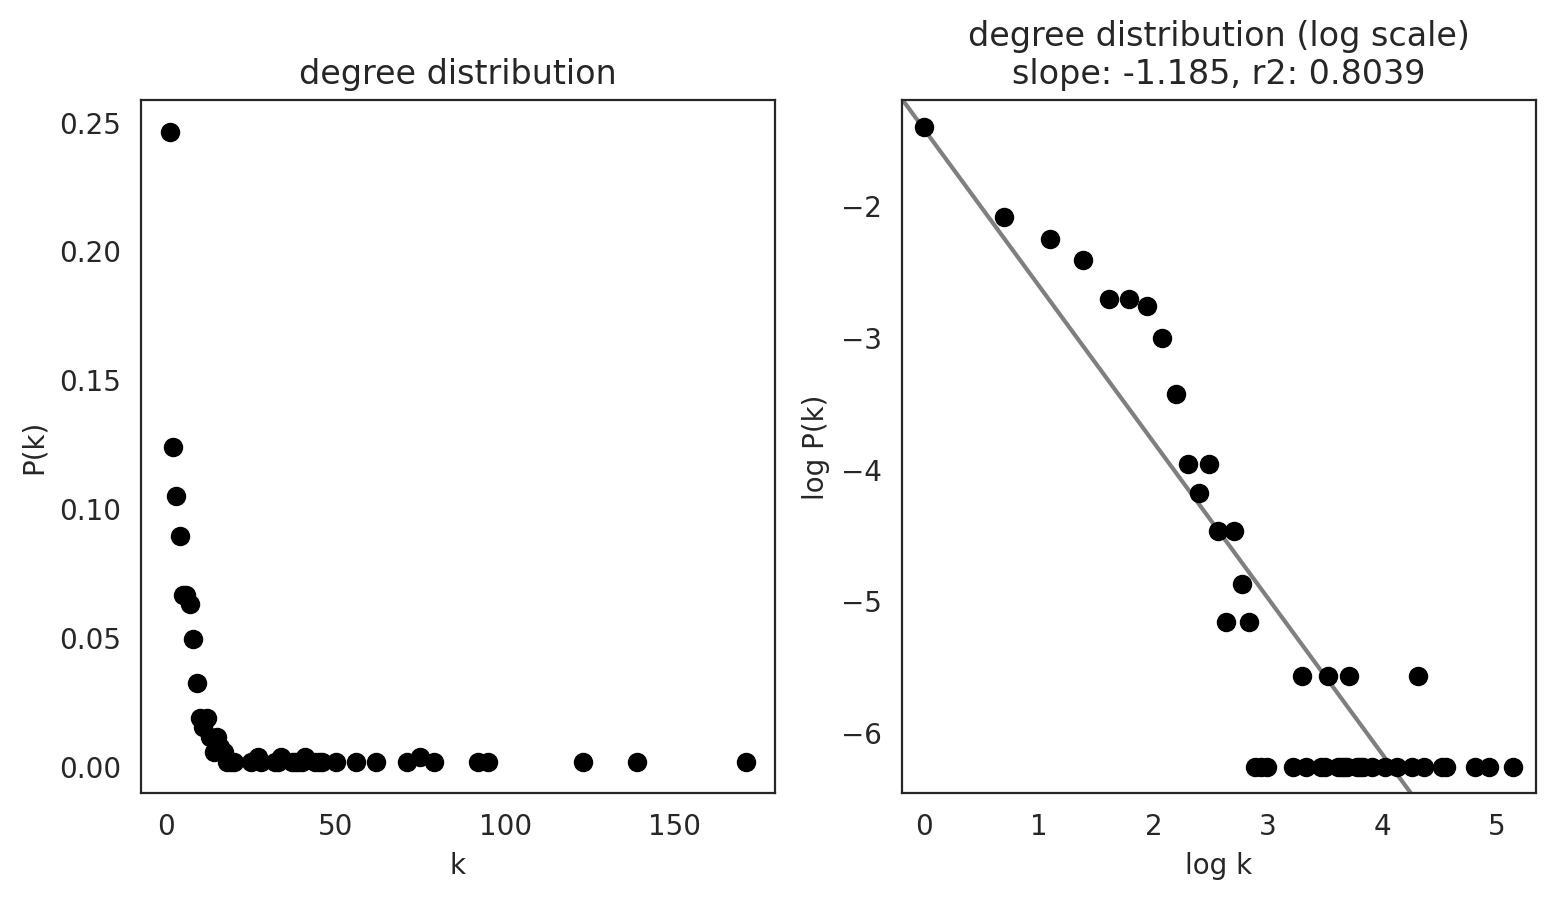


[8] Calculating network scores...
  ✓ Network scores calculated
  ✓ Filtered links saved: celloracle_results/per_celltype/Epi_Kit+Elf5+_filtered.celloracle.links

[9] Saving gene scores...
  ✓ Saved: celltype_genes/Epi_Kit+Elf5+/KO_DM_all_genes.csv
  ✓ Saved: celltype_genes/Epi_Kit+Elf5+/WT_DM_all_genes.csv

[10] Visualizing top genes...
  ✓ Top genes CSV saved

[11] Creating heatmap...
  ✓ Heatmap saved

[12] Score comparison between samples...
  Comparing: KO_DM vs WT_DM


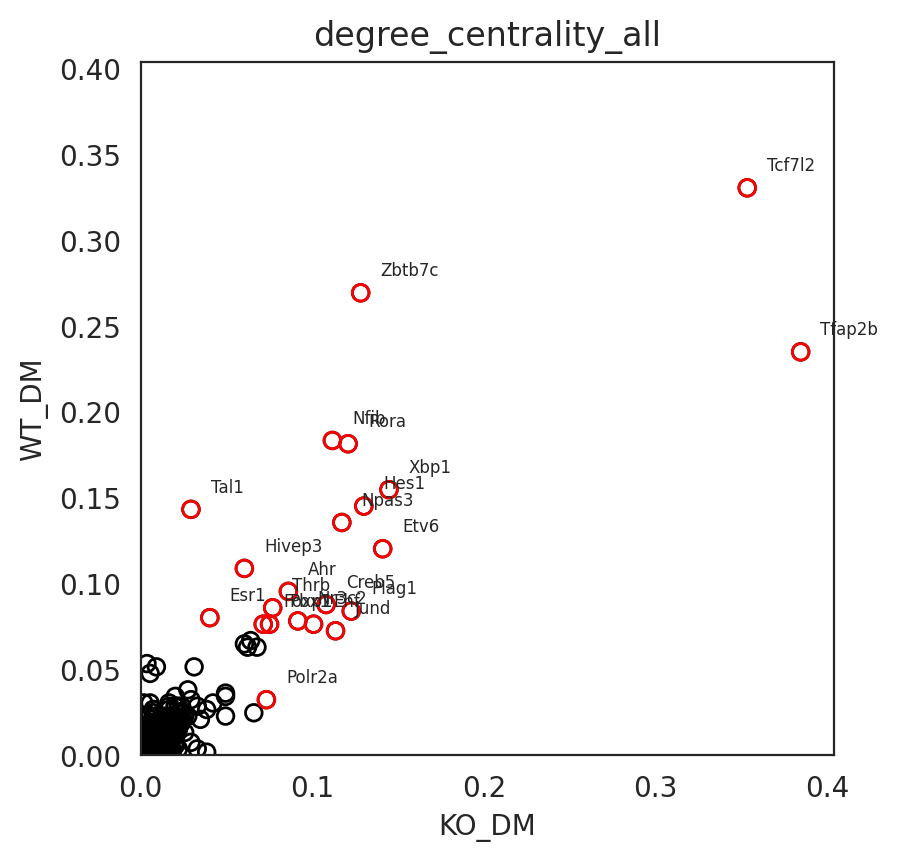

  ✓ Comparison plot saved (symmetrical axes)

  ✓ COMPLETED: Epi_Kit+Elf5+



>>> [2/14] Starting: Epi_Ctr9+

  Processing: Epi_Ctr9+

[1] Subset: 943 cells x 33696 genes
  Sample distribution:
    WT_DM: 664 cells
    KO_DM: 279 cells

[2] Preprocessing...
  After gene filtering: (943, 22092)
  Selected 2999 highly variable genes
  After HVG selection: (943, 2999)

[3] Computing embeddings...
  ✓ PCA
  ✓ Neighbors (n=30)
  ✓ UMAP

[4] Creating Oracle object...
  ✓ Data imported (cluster_column='sample')
  ✓ TF data imported

[5] KNN imputation...
  PCA components: 116
  Cell count: 943, k: 23
  ✓ KNN imputation complete
  ✓ Oracle saved: celloracle_results/per_celltype/Epi_Ctr9+.celloracle.oracle

[6] GRN calculation (by sample)...


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for KO_DM...


  0%|          | 0/2140 [00:00<?, ?it/s]

Inferring GRN for WT_DM...


  0%|          | 0/2140 [00:00<?, ?it/s]

  ✓ Links saved: celloracle_results/per_celltype/Epi_Ctr9+.celloracle.links

[7] Network preprocessing...
  ✓ Links filtered
KO_DM


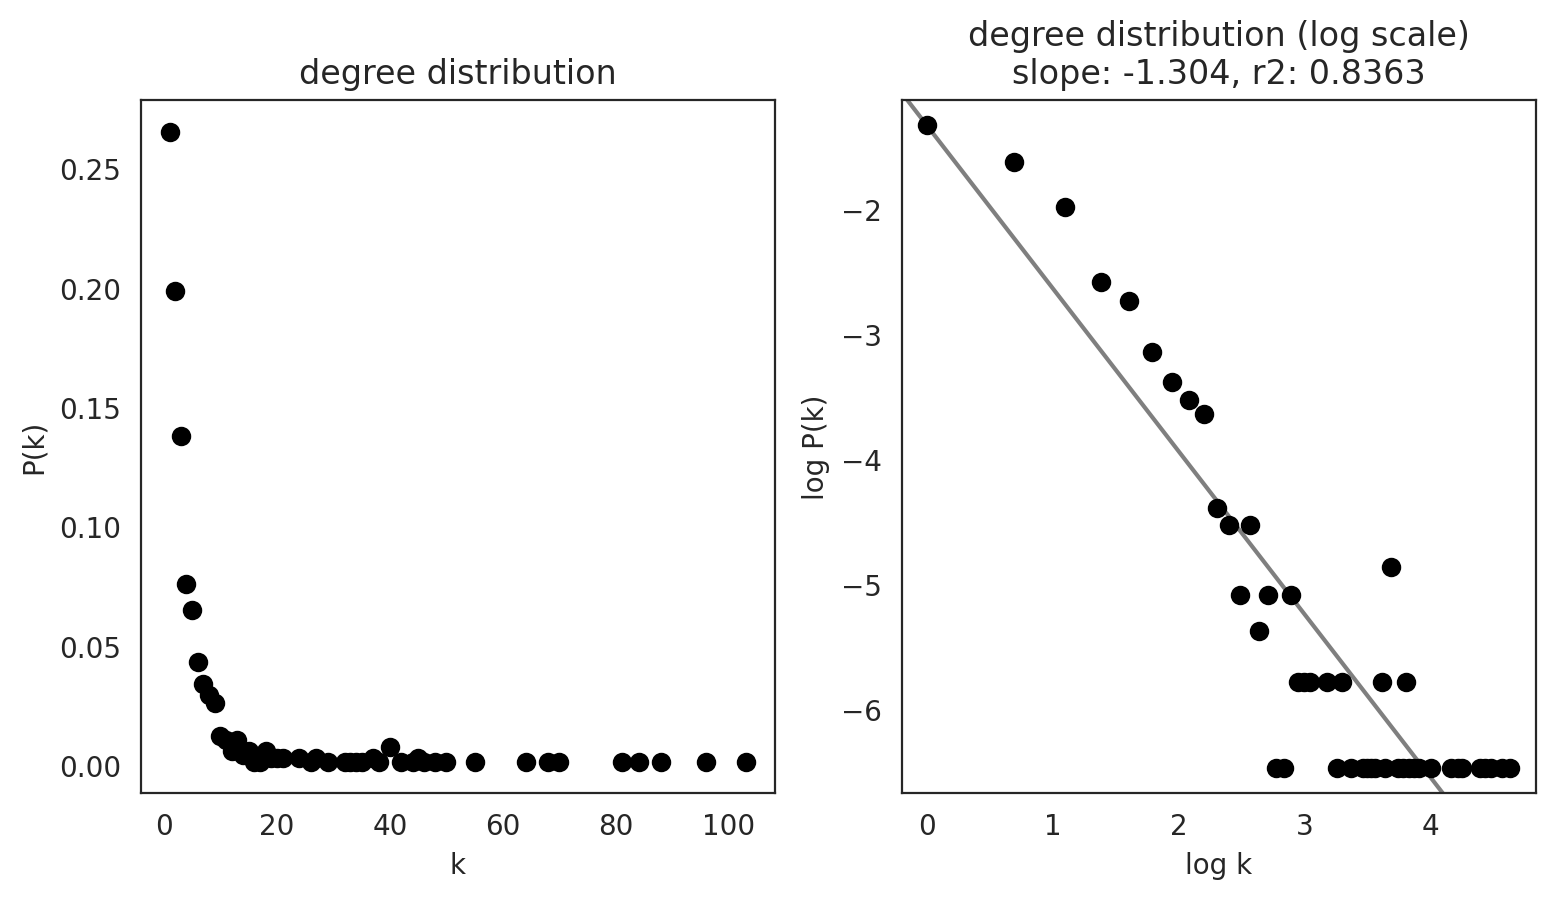

WT_DM


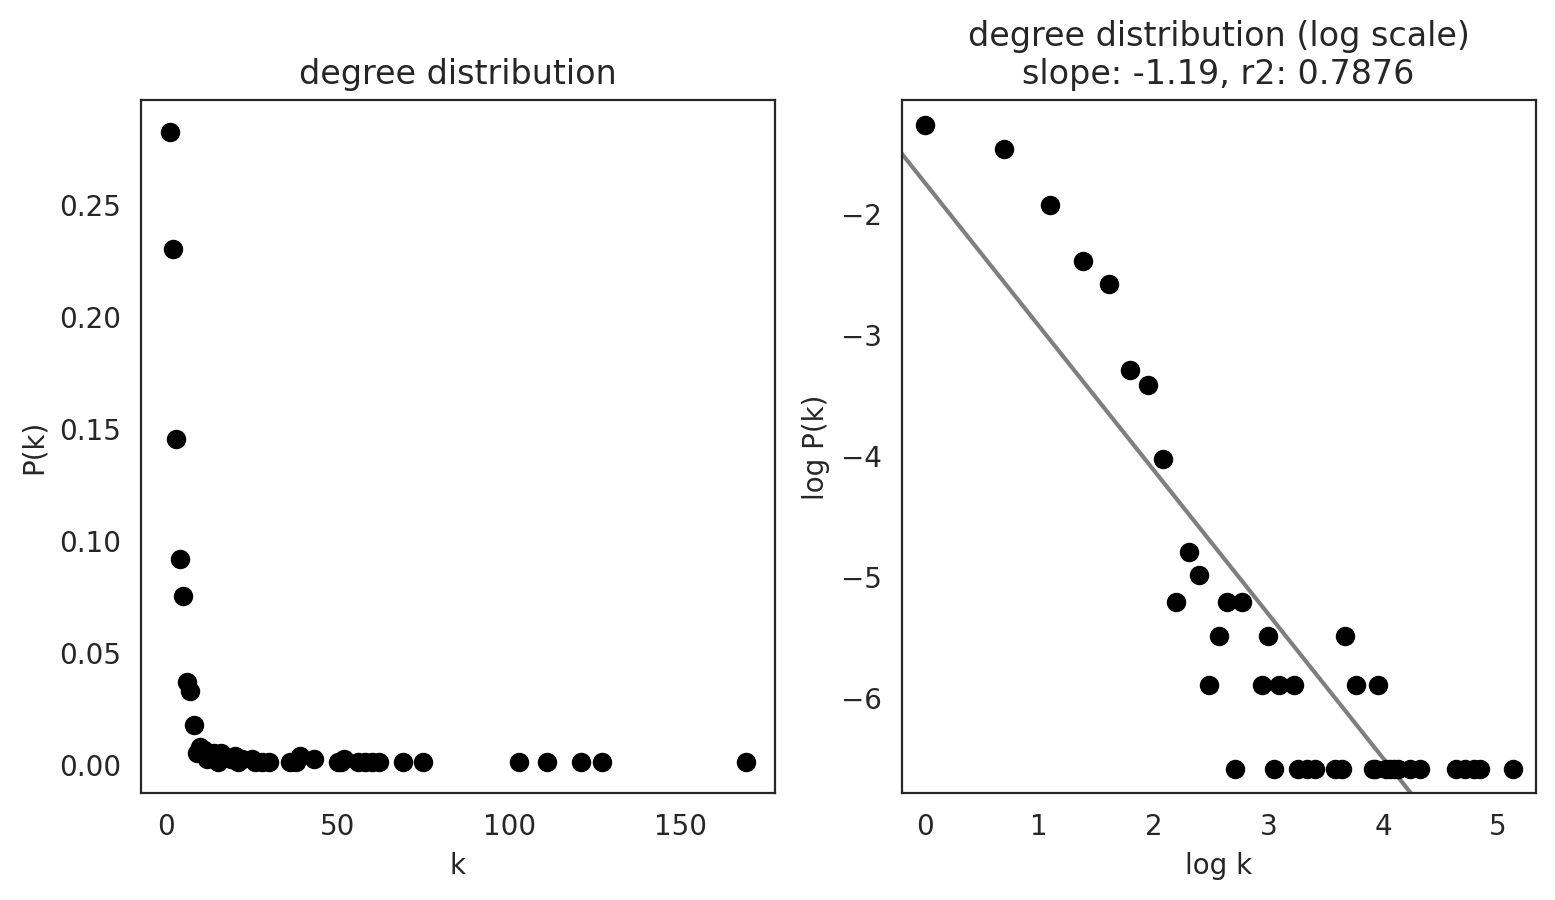


[8] Calculating network scores...
  ✓ Network scores calculated
  ✓ Filtered links saved: celloracle_results/per_celltype/Epi_Ctr9+_filtered.celloracle.links

[9] Saving gene scores...
  ✓ Saved: celltype_genes/Epi_Ctr9+/KO_DM_all_genes.csv
  ✓ Saved: celltype_genes/Epi_Ctr9+/WT_DM_all_genes.csv

[10] Visualizing top genes...
  ✓ Top genes CSV saved

[11] Creating heatmap...
  ✓ Heatmap saved

[12] Score comparison between samples...
  Comparing: KO_DM vs WT_DM


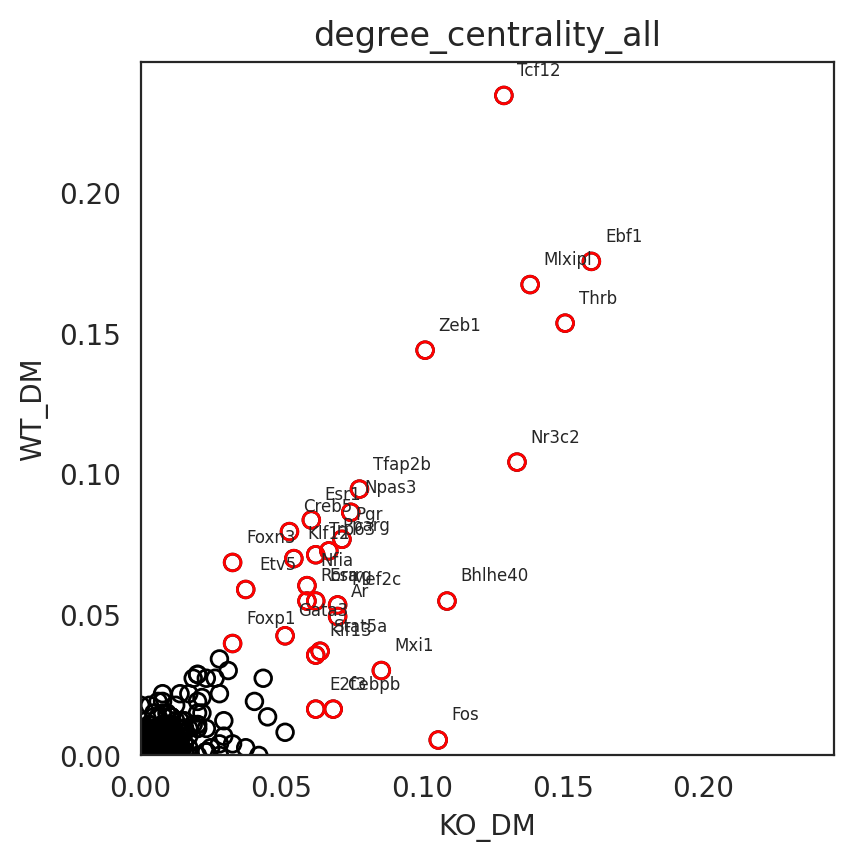

  ✓ Comparison plot saved (symmetrical axes)

  ✓ COMPLETED: Epi_Ctr9+



>>> [3/14] Starting: Bcells

  Processing: Bcells

[1] Subset: 519 cells x 33696 genes
  Sample distribution:
    WT_DM: 307 cells
    KO_DM: 212 cells

[2] Preprocessing...
  After gene filtering: (519, 19069)
  Selected 2999 highly variable genes
  After HVG selection: (519, 2999)

[3] Computing embeddings...
  ✓ PCA
  ✓ Neighbors (n=30)
  ✓ UMAP

[4] Creating Oracle object...
  ✓ Data imported (cluster_column='sample')
  ✓ TF data imported

[5] KNN imputation...
  PCA components: 165
  Cell count: 519, k: 12
  ✓ KNN imputation complete
  ✓ Oracle saved: celloracle_results/per_celltype/Bcells.celloracle.oracle

[6] GRN calculation (by sample)...


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for KO_DM...


  0%|          | 0/2051 [00:00<?, ?it/s]

Inferring GRN for WT_DM...


  0%|          | 0/2051 [00:00<?, ?it/s]

  ✓ Links saved: celloracle_results/per_celltype/Bcells.celloracle.links

[7] Network preprocessing...
  ✓ Links filtered
KO_DM


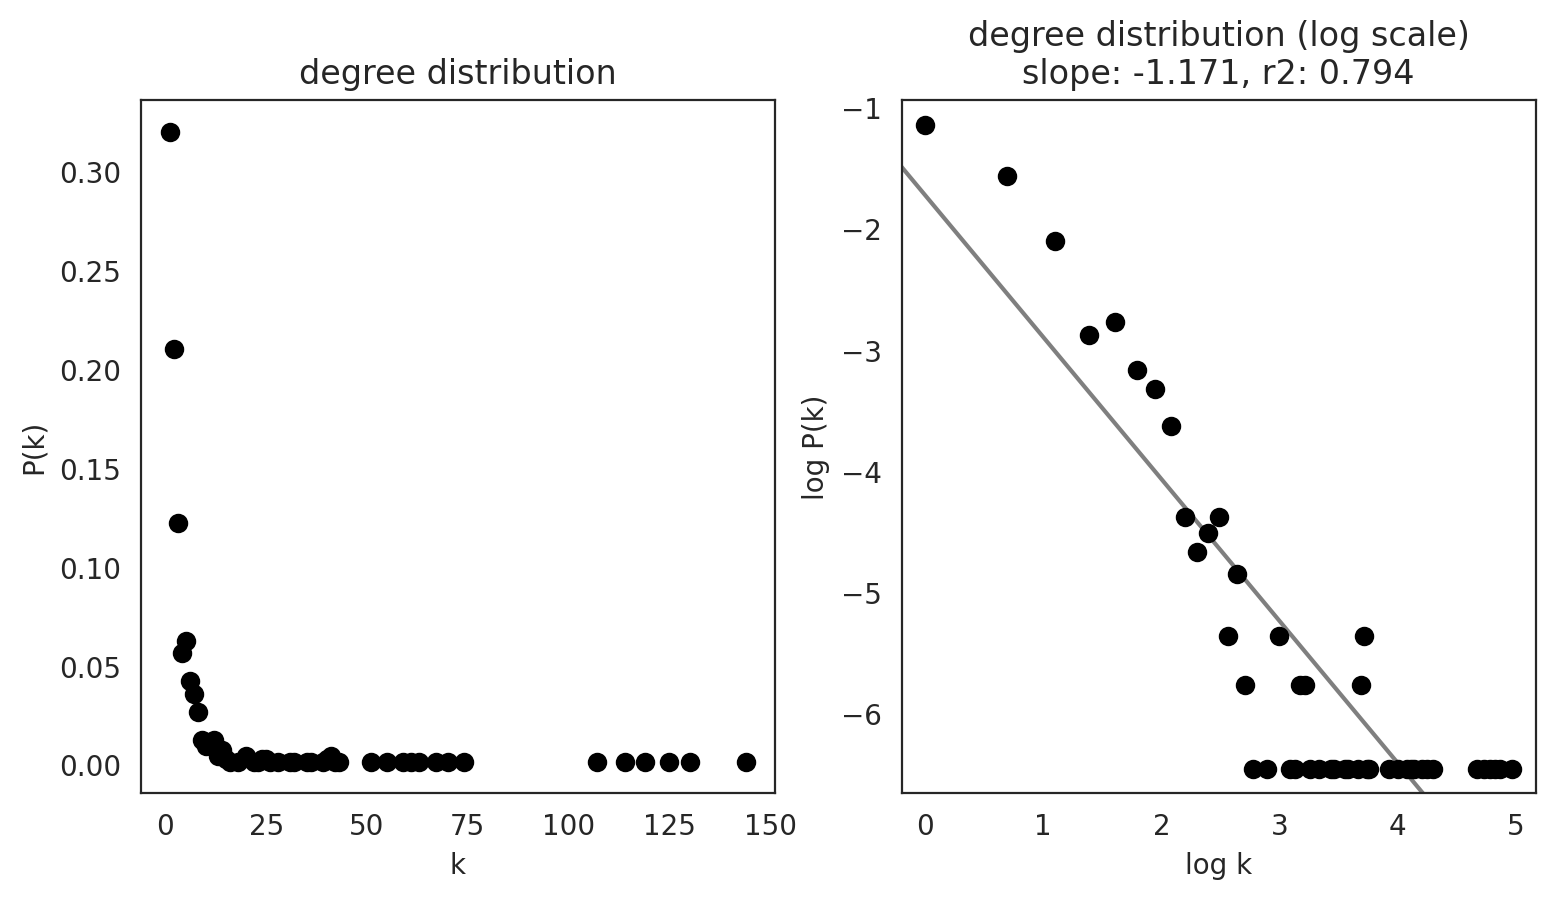

WT_DM


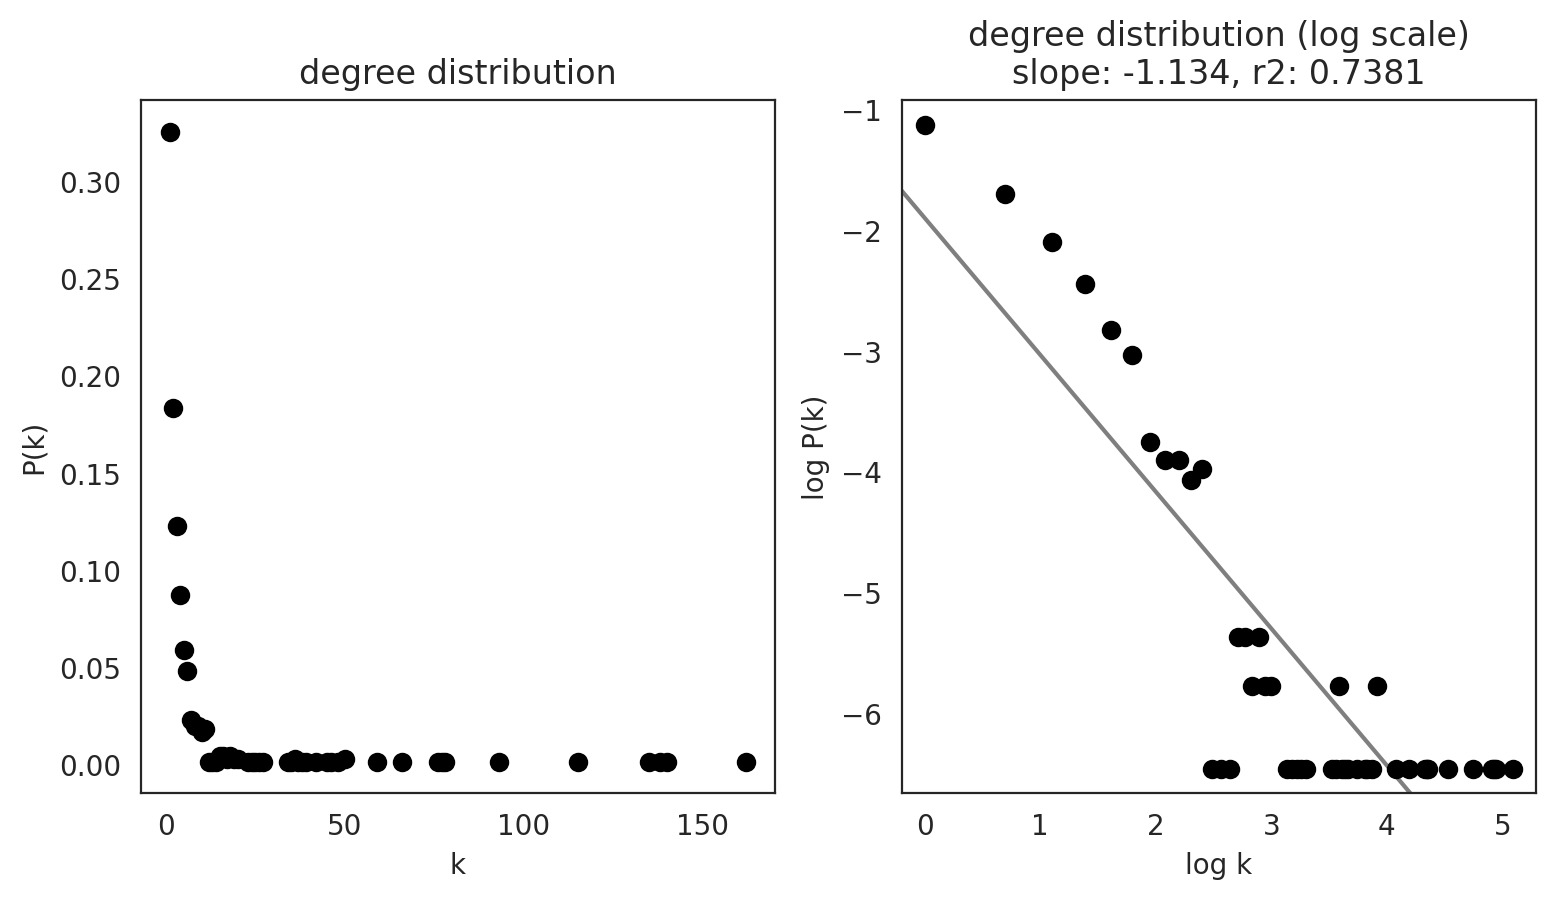


[8] Calculating network scores...
  ✓ Network scores calculated
  ✓ Filtered links saved: celloracle_results/per_celltype/Bcells_filtered.celloracle.links

[9] Saving gene scores...
  ✓ Saved: celltype_genes/Bcells/KO_DM_all_genes.csv
  ✓ Saved: celltype_genes/Bcells/WT_DM_all_genes.csv

[10] Visualizing top genes...
  ✓ Top genes CSV saved

[11] Creating heatmap...
  ✓ Heatmap saved

[12] Score comparison between samples...
  Comparing: KO_DM vs WT_DM


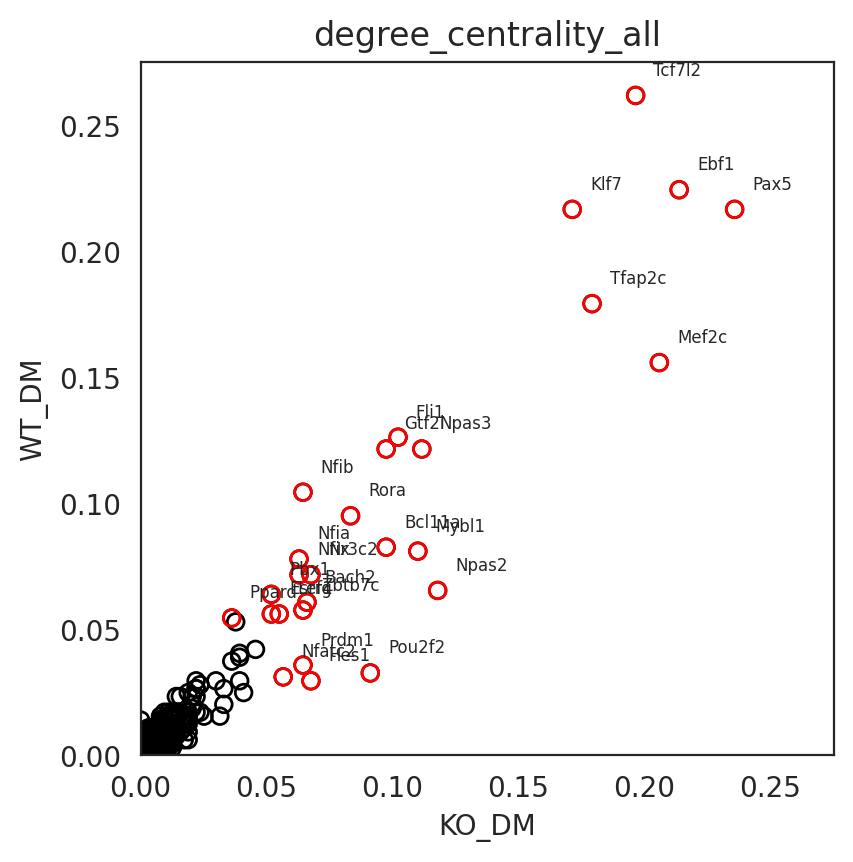

  ✓ Comparison plot saved (symmetrical axes)

  ✓ COMPLETED: Bcells



>>> [4/14] Starting: Pericytes/SMC

  Processing: Pericytes/SMC

[1] Subset: 142 cells x 33696 genes
  Sample distribution:
    KO_DM: 89 cells
    WT_DM: 53 cells

[2] Preprocessing...
  After gene filtering: (142, 14824)
  Selected 2999 highly variable genes
  After HVG selection: (142, 2999)

[3] Computing embeddings...
  ✓ PCA
  ✓ Neighbors (n=30)
  ✓ UMAP

[4] Creating Oracle object...
  ✓ Data imported (cluster_column='sample')
  ✓ TF data imported

[5] KNN imputation...
  PCA components: 139
  Cell count: 142, k: 5
  ✓ KNN imputation complete
  ✓ Oracle saved: celloracle_results/per_celltype/Pericytes_SMC.celloracle.oracle

[6] GRN calculation (by sample)...


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for KO_DM...


  0%|          | 0/2240 [00:00<?, ?it/s]

Inferring GRN for WT_DM...


  0%|          | 0/2240 [00:00<?, ?it/s]

  ✓ Links saved: celloracle_results/per_celltype/Pericytes_SMC.celloracle.links

[7] Network preprocessing...
  ✓ Links filtered
KO_DM


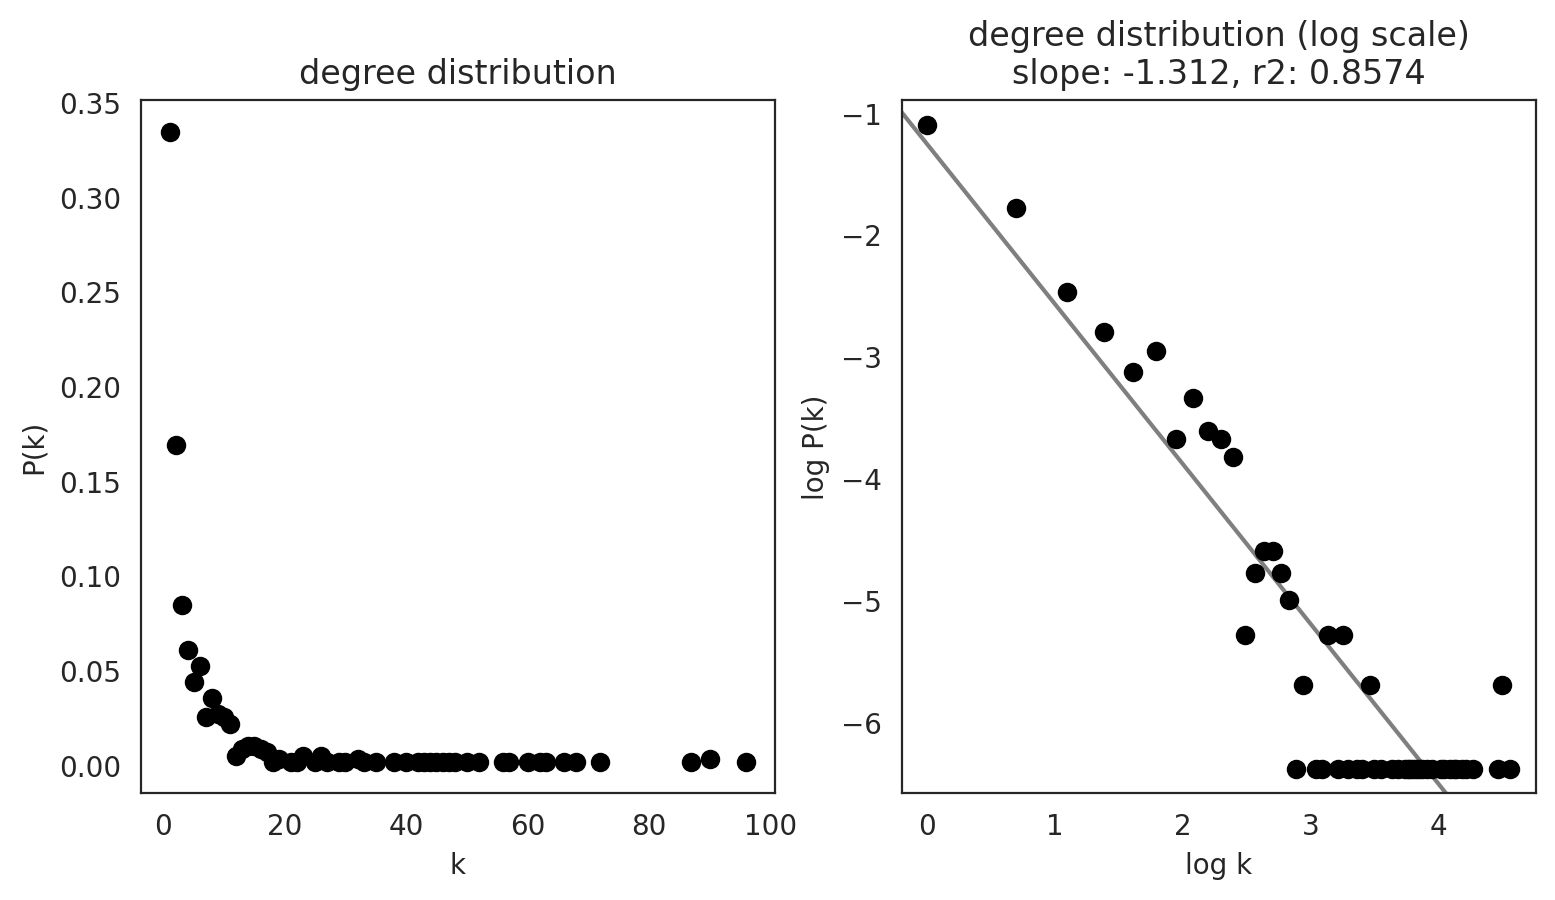

WT_DM


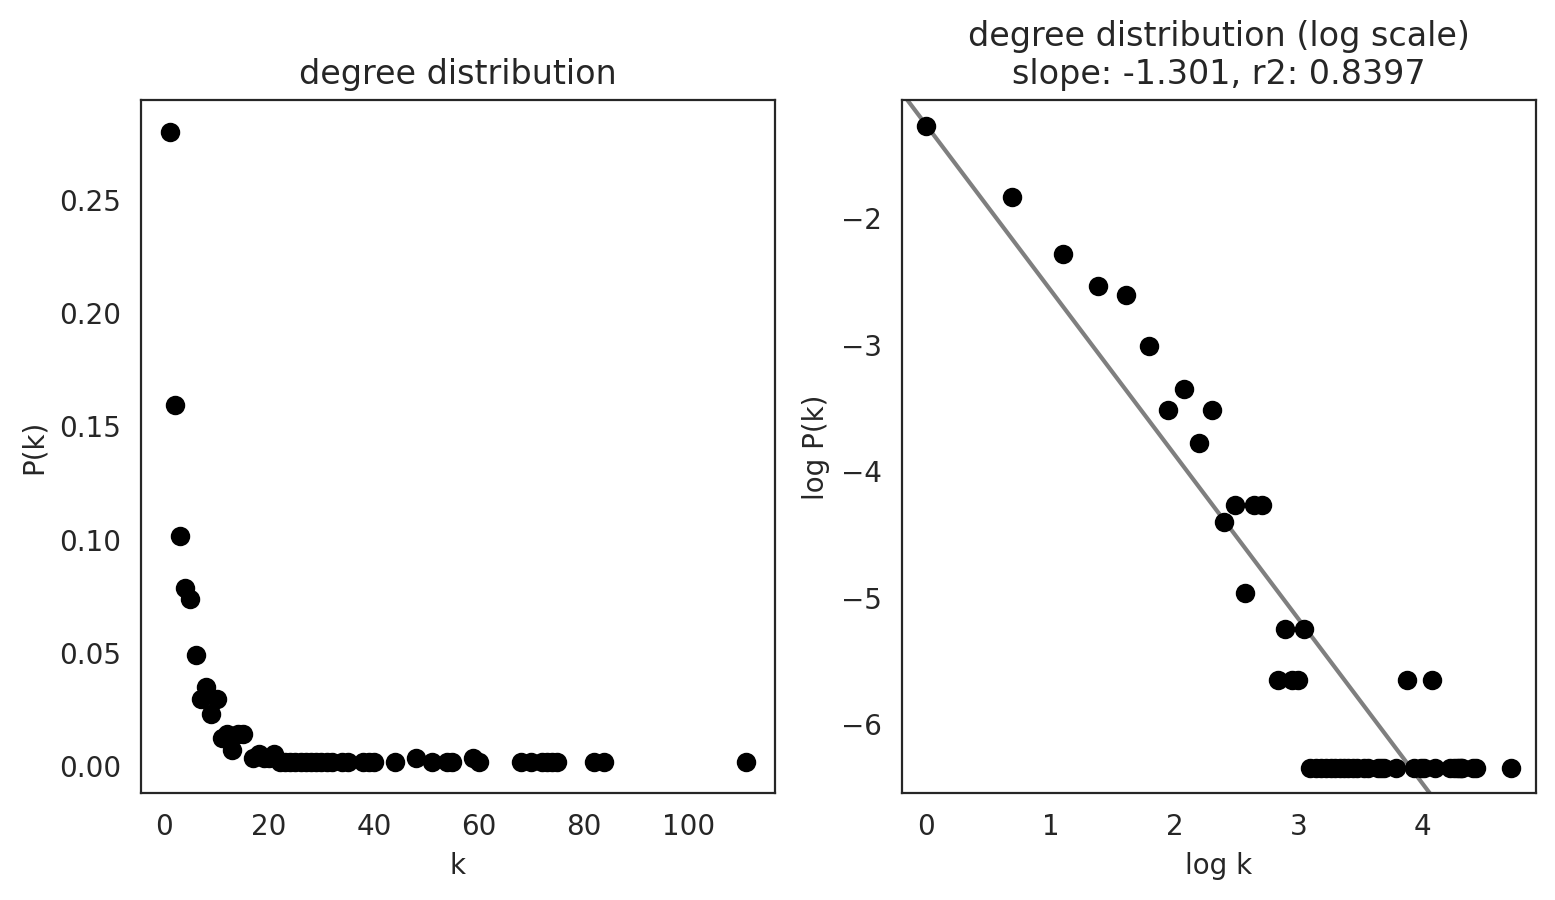


[8] Calculating network scores...
  ✓ Network scores calculated
  ✓ Filtered links saved: celloracle_results/per_celltype/Pericytes_SMC_filtered.celloracle.links

[9] Saving gene scores...
  ✓ Saved: celltype_genes/Pericytes_SMC/KO_DM_all_genes.csv
  ✓ Saved: celltype_genes/Pericytes_SMC/WT_DM_all_genes.csv

[10] Visualizing top genes...
  ✓ Top genes CSV saved

[11] Creating heatmap...
  ✓ Heatmap saved

[12] Score comparison between samples...
  Comparing: KO_DM vs WT_DM


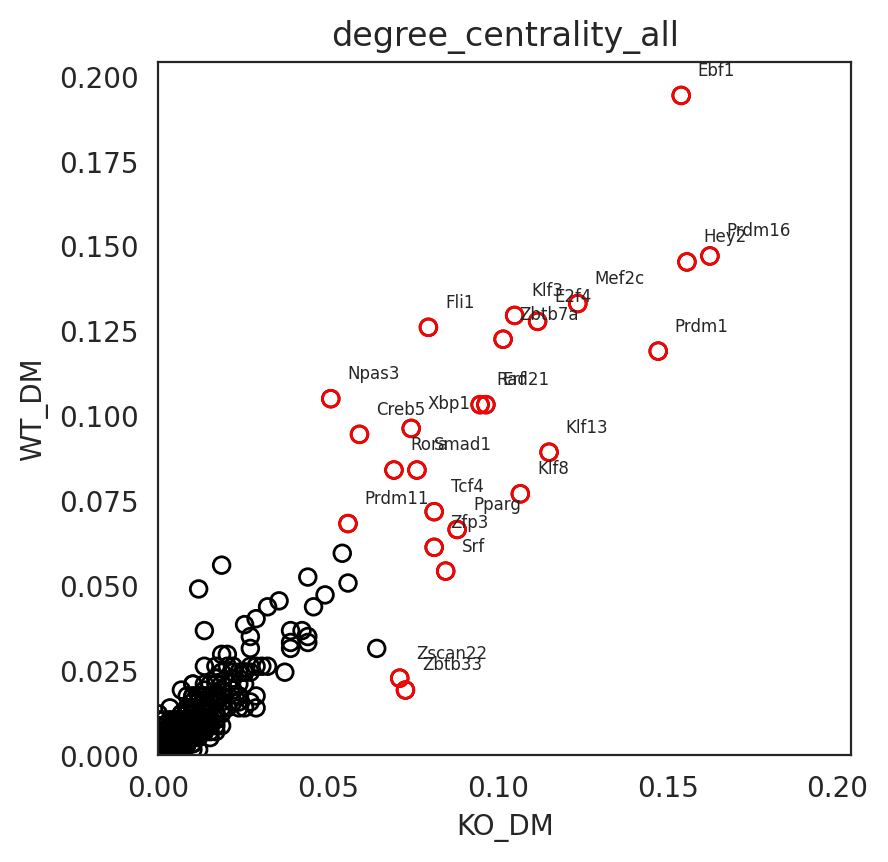

  ✓ Comparison plot saved (symmetrical axes)

  ✓ COMPLETED: Pericytes/SMC



>>> [5/14] Starting: BasalEpi_Acta2+Trp63

  Processing: BasalEpi_Acta2+Trp63

[1] Subset: 1066 cells x 33696 genes
  Sample distribution:
    KO_DM: 547 cells
    WT_DM: 519 cells

[2] Preprocessing...
  After gene filtering: (1066, 21250)
  Selected 2993 highly variable genes
  After HVG selection: (1066, 2993)

[3] Computing embeddings...
  ✓ PCA
  ✓ Neighbors (n=30)
  ✓ UMAP

[4] Creating Oracle object...
  ✓ Data imported (cluster_column='sample')
  ✓ TF data imported

[5] KNN imputation...
  PCA components: 128
  Cell count: 1066, k: 26
  ✓ KNN imputation complete
  ✓ Oracle saved: celloracle_results/per_celltype/BasalEpi_Acta2+Trp63.celloracle.oracle

[6] GRN calculation (by sample)...


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for KO_DM...


  0%|          | 0/2011 [00:00<?, ?it/s]

Inferring GRN for WT_DM...


  0%|          | 0/2011 [00:00<?, ?it/s]

  ✓ Links saved: celloracle_results/per_celltype/BasalEpi_Acta2+Trp63.celloracle.links

[7] Network preprocessing...
  ✓ Links filtered
KO_DM


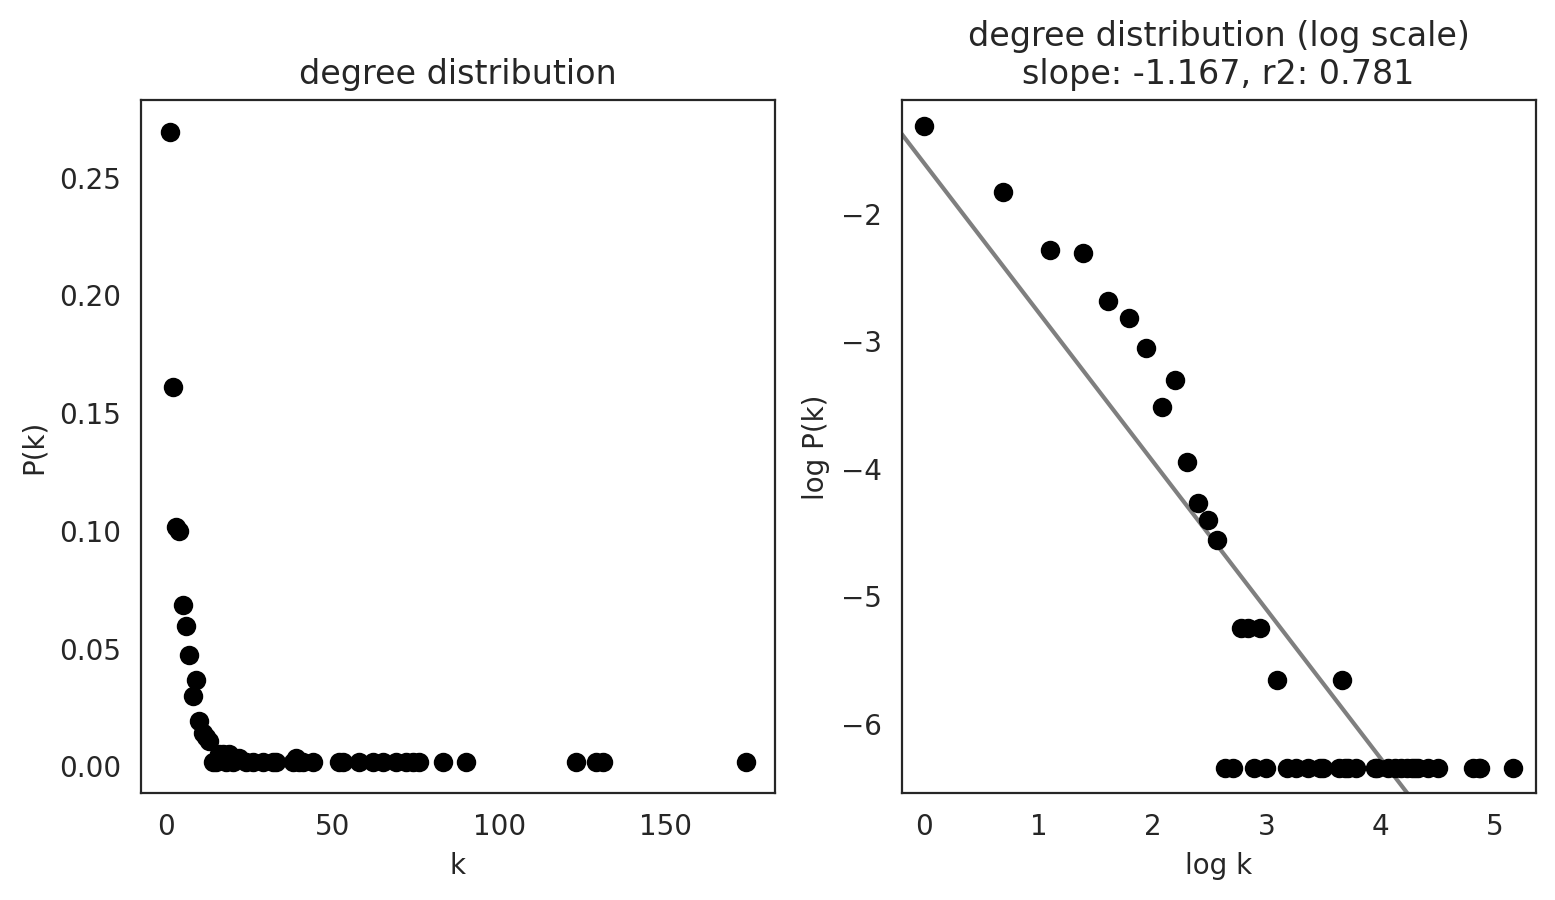

WT_DM


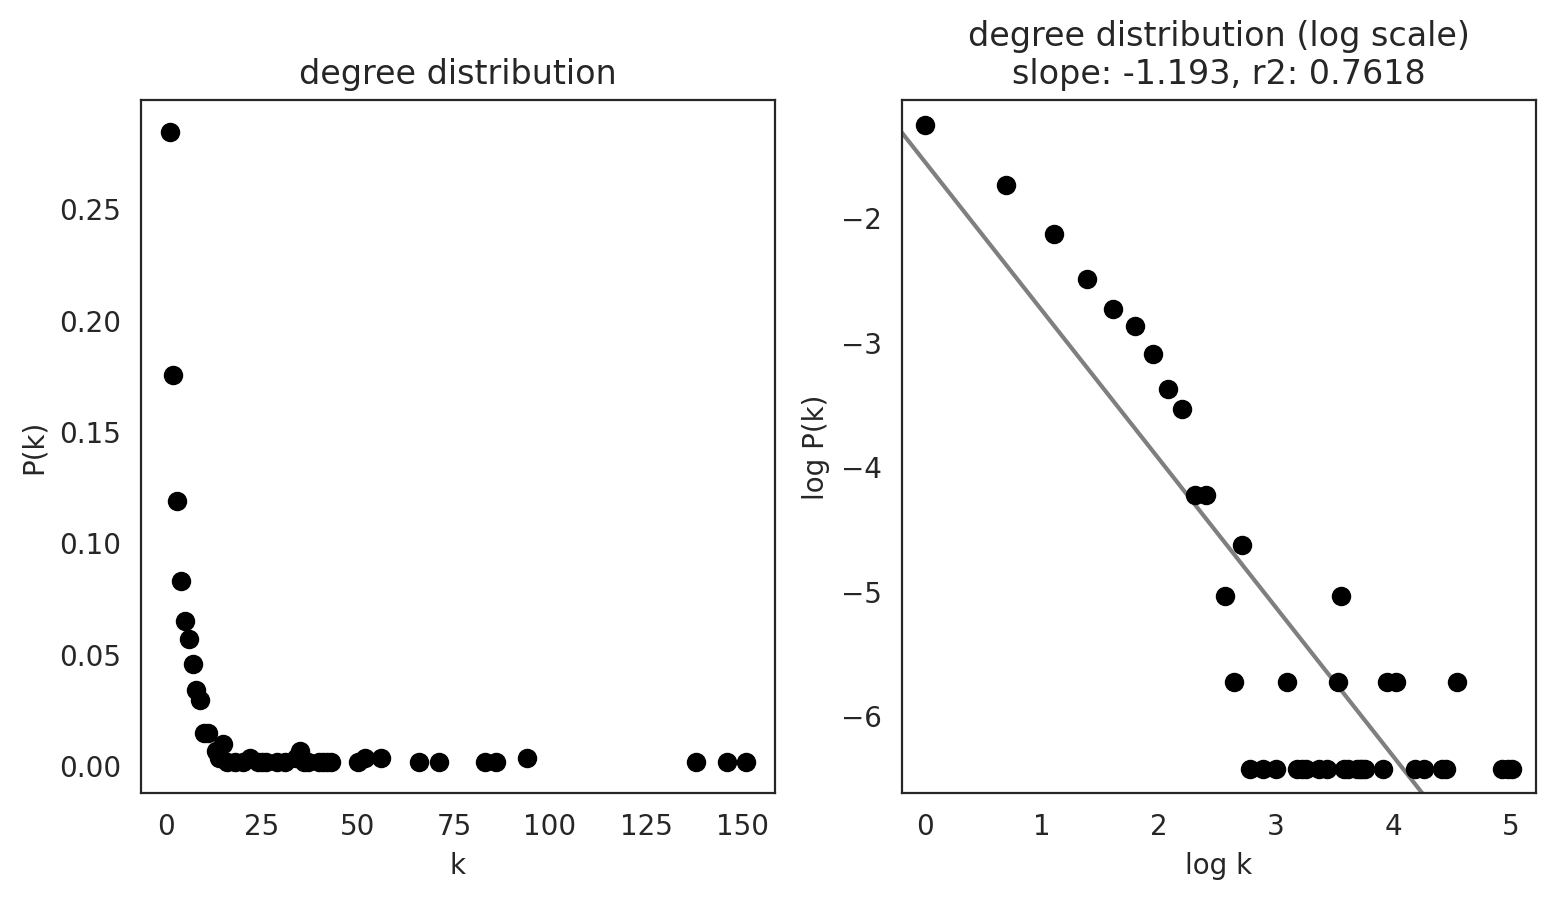


[8] Calculating network scores...
  ✓ Network scores calculated
  ✓ Filtered links saved: celloracle_results/per_celltype/BasalEpi_Acta2+Trp63_filtered.celloracle.links

[9] Saving gene scores...
  ✓ Saved: celltype_genes/BasalEpi_Acta2+Trp63/KO_DM_all_genes.csv
  ✓ Saved: celltype_genes/BasalEpi_Acta2+Trp63/WT_DM_all_genes.csv

[10] Visualizing top genes...
  ✓ Top genes CSV saved

[11] Creating heatmap...
  ✓ Heatmap saved

[12] Score comparison between samples...
  Comparing: KO_DM vs WT_DM


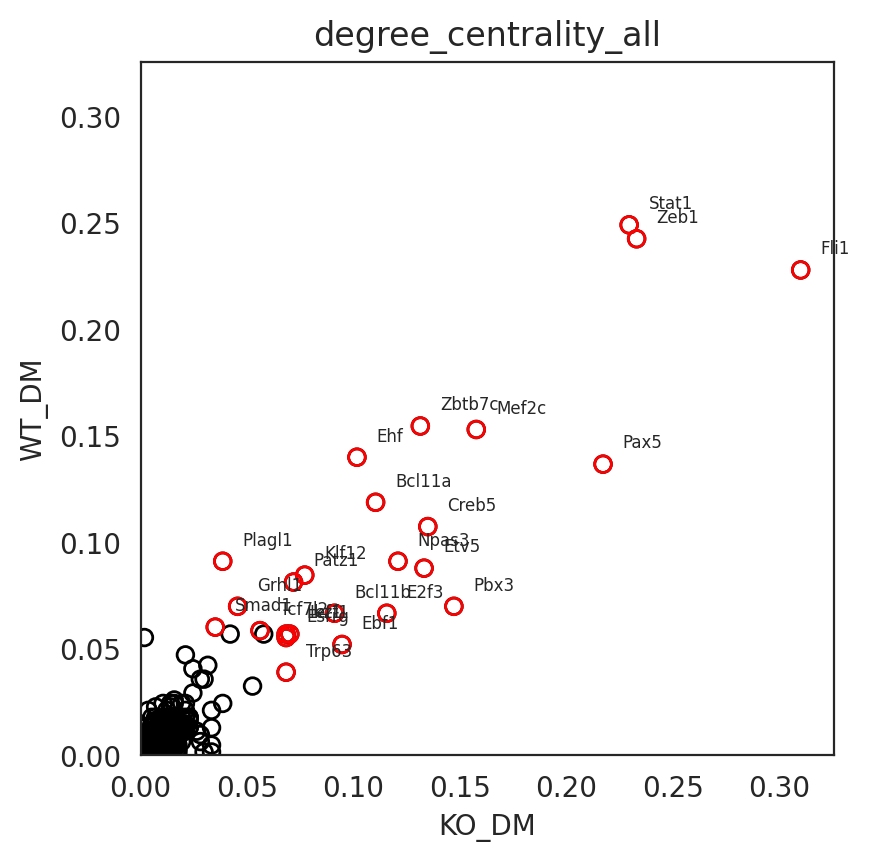

  ✓ Comparison plot saved (symmetrical axes)

  ✓ COMPLETED: BasalEpi_Acta2+Trp63



>>> [6/14] Starting: Adipocyte

  Processing: Adipocyte

[1] Subset: 1802 cells x 33696 genes
  Sample distribution:
    WT_DM: 1087 cells
    KO_DM: 715 cells

[2] Preprocessing...
  After gene filtering: (1802, 22673)
  Selected 3000 highly variable genes
  After HVG selection: (1802, 3000)

[3] Computing embeddings...
  ✓ PCA
  ✓ Neighbors (n=30)
  ✓ UMAP

[4] Creating Oracle object...
  ✓ Data imported (cluster_column='sample')
  ✓ TF data imported

[5] KNN imputation...
  PCA components: 90
  Cell count: 1802, k: 45
  ✓ KNN imputation complete
  ✓ Oracle saved: celloracle_results/per_celltype/Adipocyte.celloracle.oracle

[6] GRN calculation (by sample)...


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for KO_DM...


  0%|          | 0/1966 [00:00<?, ?it/s]

Inferring GRN for WT_DM...


  0%|          | 0/1966 [00:00<?, ?it/s]

  ✓ Links saved: celloracle_results/per_celltype/Adipocyte.celloracle.links

[7] Network preprocessing...
  ✓ Links filtered
KO_DM


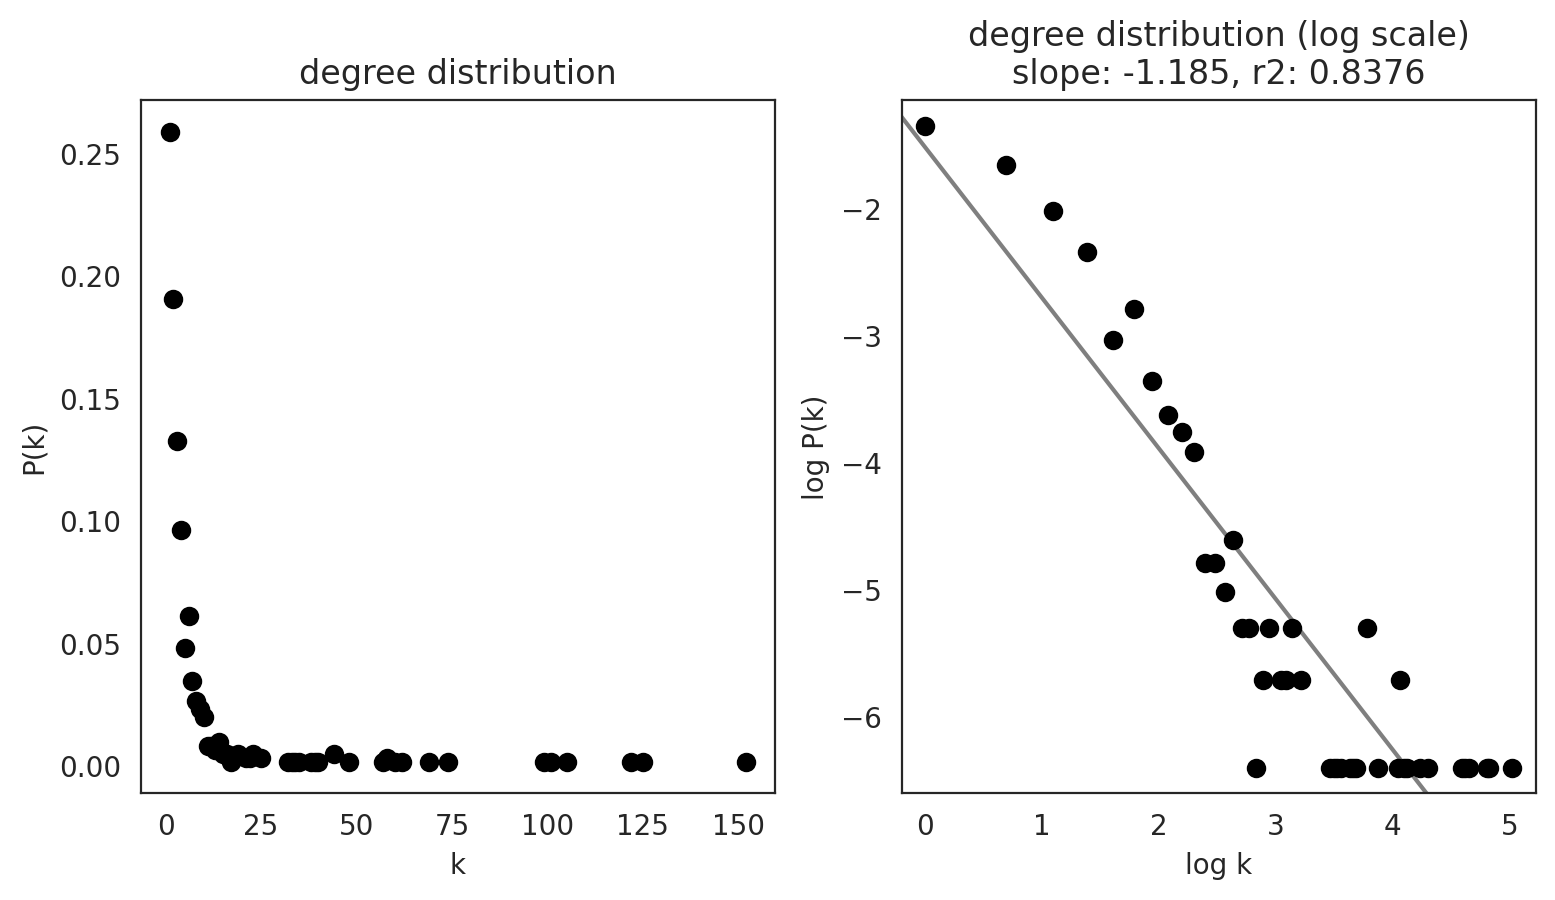

WT_DM


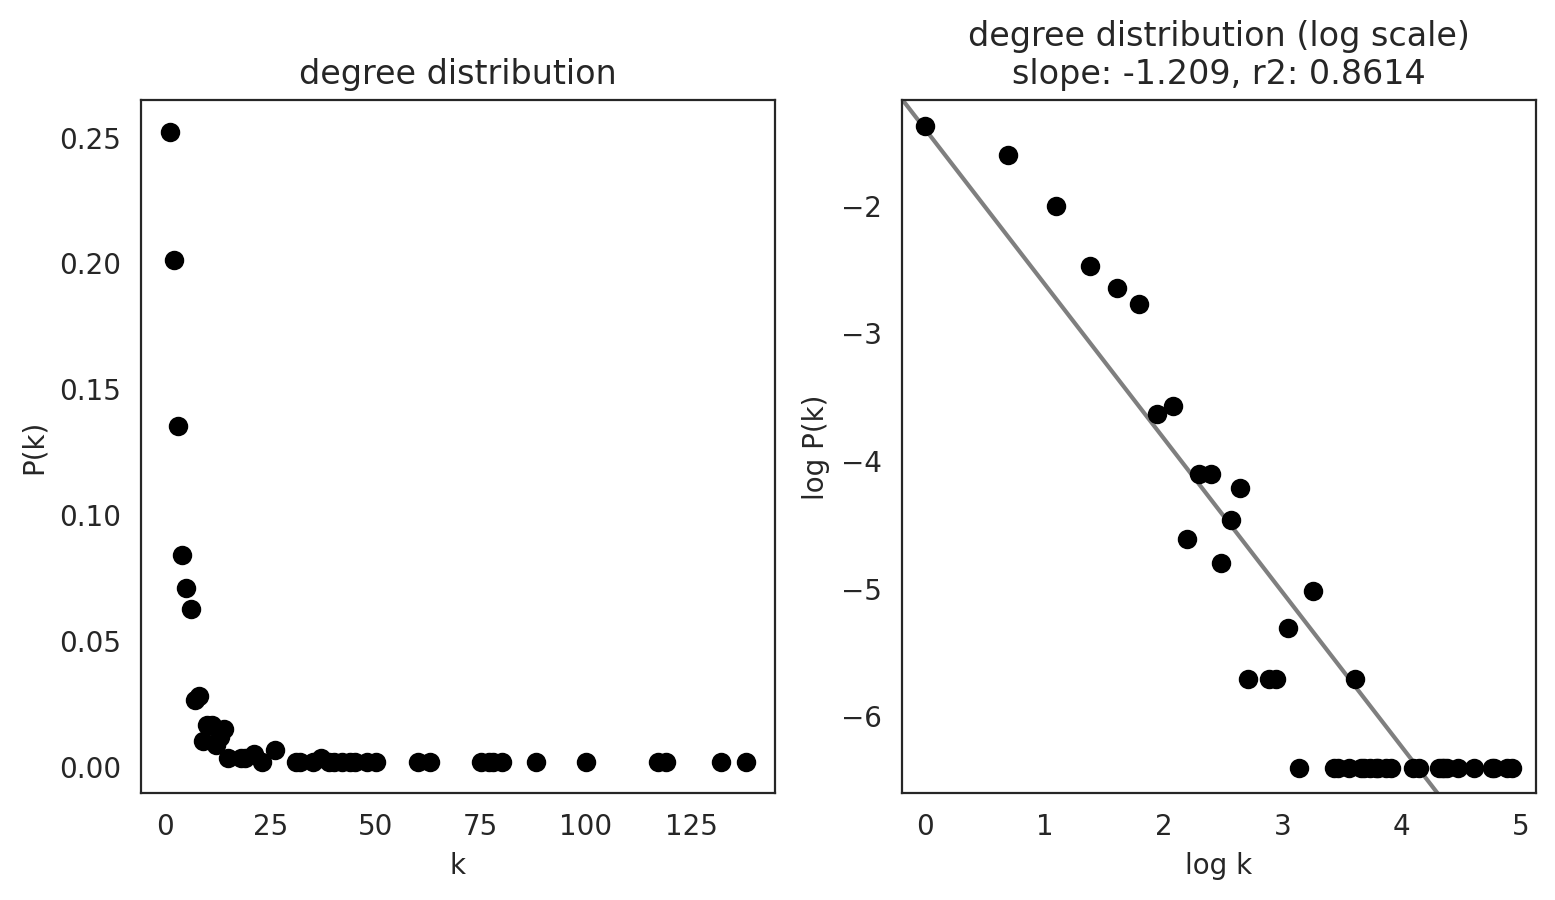


[8] Calculating network scores...
  ✓ Network scores calculated
  ✓ Filtered links saved: celloracle_results/per_celltype/Adipocyte_filtered.celloracle.links

[9] Saving gene scores...
  ✓ Saved: celltype_genes/Adipocyte/KO_DM_all_genes.csv
  ✓ Saved: celltype_genes/Adipocyte/WT_DM_all_genes.csv

[10] Visualizing top genes...
  ✓ Top genes CSV saved

[11] Creating heatmap...
  ✓ Heatmap saved

[12] Score comparison between samples...
  Comparing: KO_DM vs WT_DM


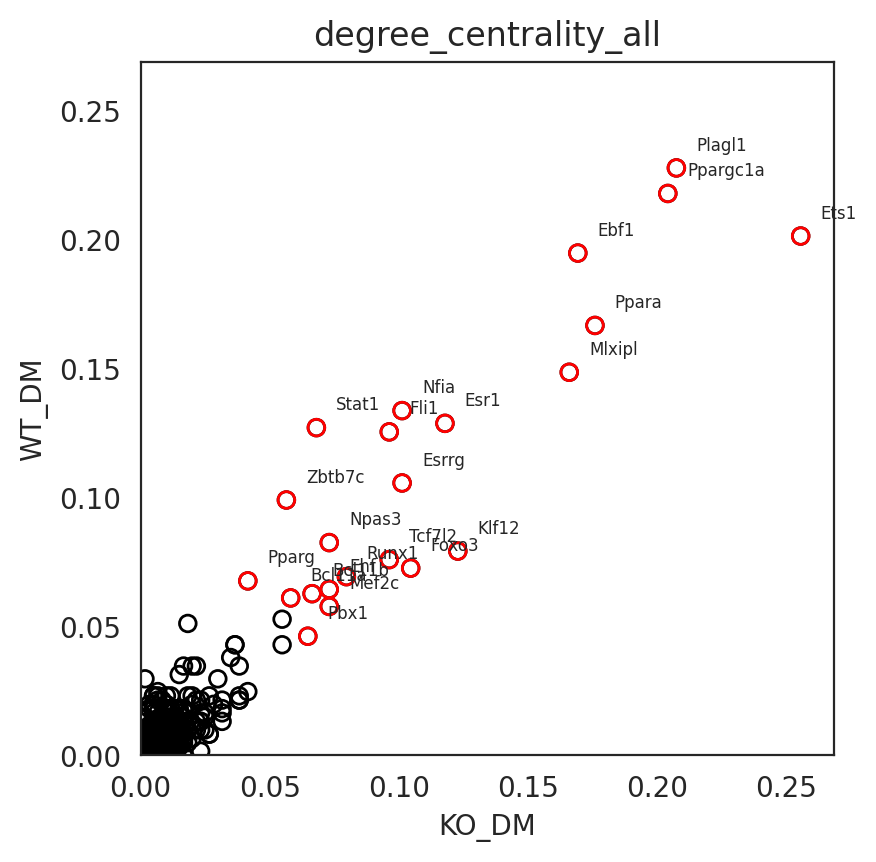

  ✓ Comparison plot saved (symmetrical axes)

  ✓ COMPLETED: Adipocyte



>>> [7/14] Starting: Endothelials

  Processing: Endothelials

[1] Subset: 442 cells x 33696 genes
  Sample distribution:
    KO_DM: 284 cells
    WT_DM: 158 cells

[2] Preprocessing...
  After gene filtering: (442, 17282)
  Selected 2999 highly variable genes
  After HVG selection: (442, 2999)

[3] Computing embeddings...
  ✓ PCA
  ✓ Neighbors (n=30)
  ✓ UMAP

[4] Creating Oracle object...
  ✓ Data imported (cluster_column='sample')
  ✓ TF data imported

[5] KNN imputation...
  PCA components: 176
  Cell count: 442, k: 11
  ✓ KNN imputation complete
  ✓ Oracle saved: celloracle_results/per_celltype/Endothelials.celloracle.oracle

[6] GRN calculation (by sample)...


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for KO_DM...


  0%|          | 0/2150 [00:00<?, ?it/s]

Inferring GRN for WT_DM...


  0%|          | 0/2150 [00:00<?, ?it/s]

  ✓ Links saved: celloracle_results/per_celltype/Endothelials.celloracle.links

[7] Network preprocessing...
  ✓ Links filtered
KO_DM


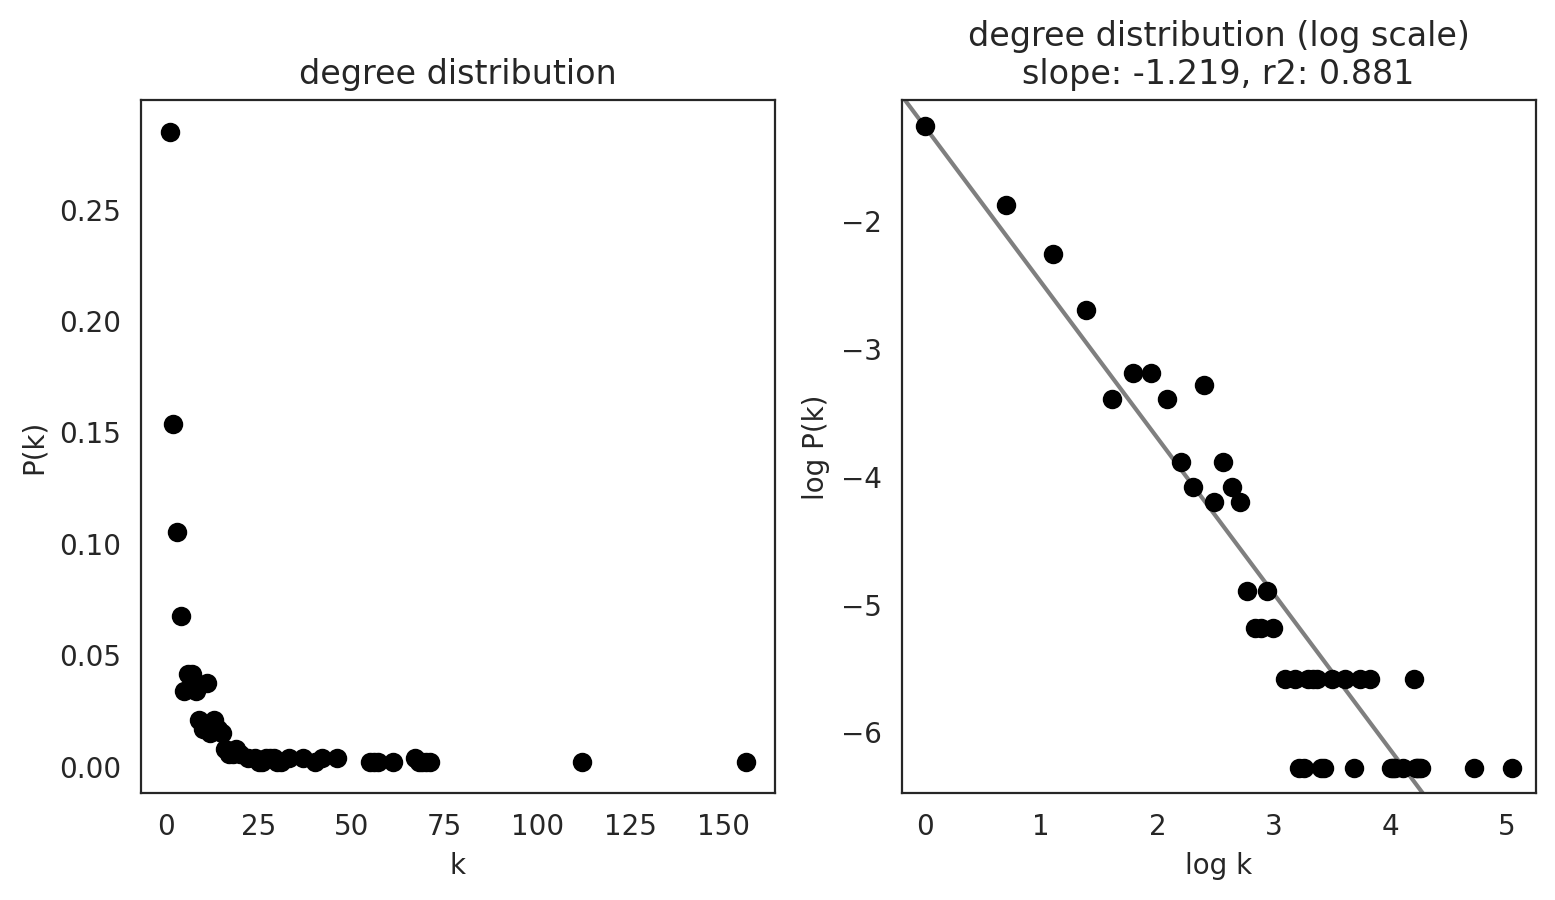

WT_DM


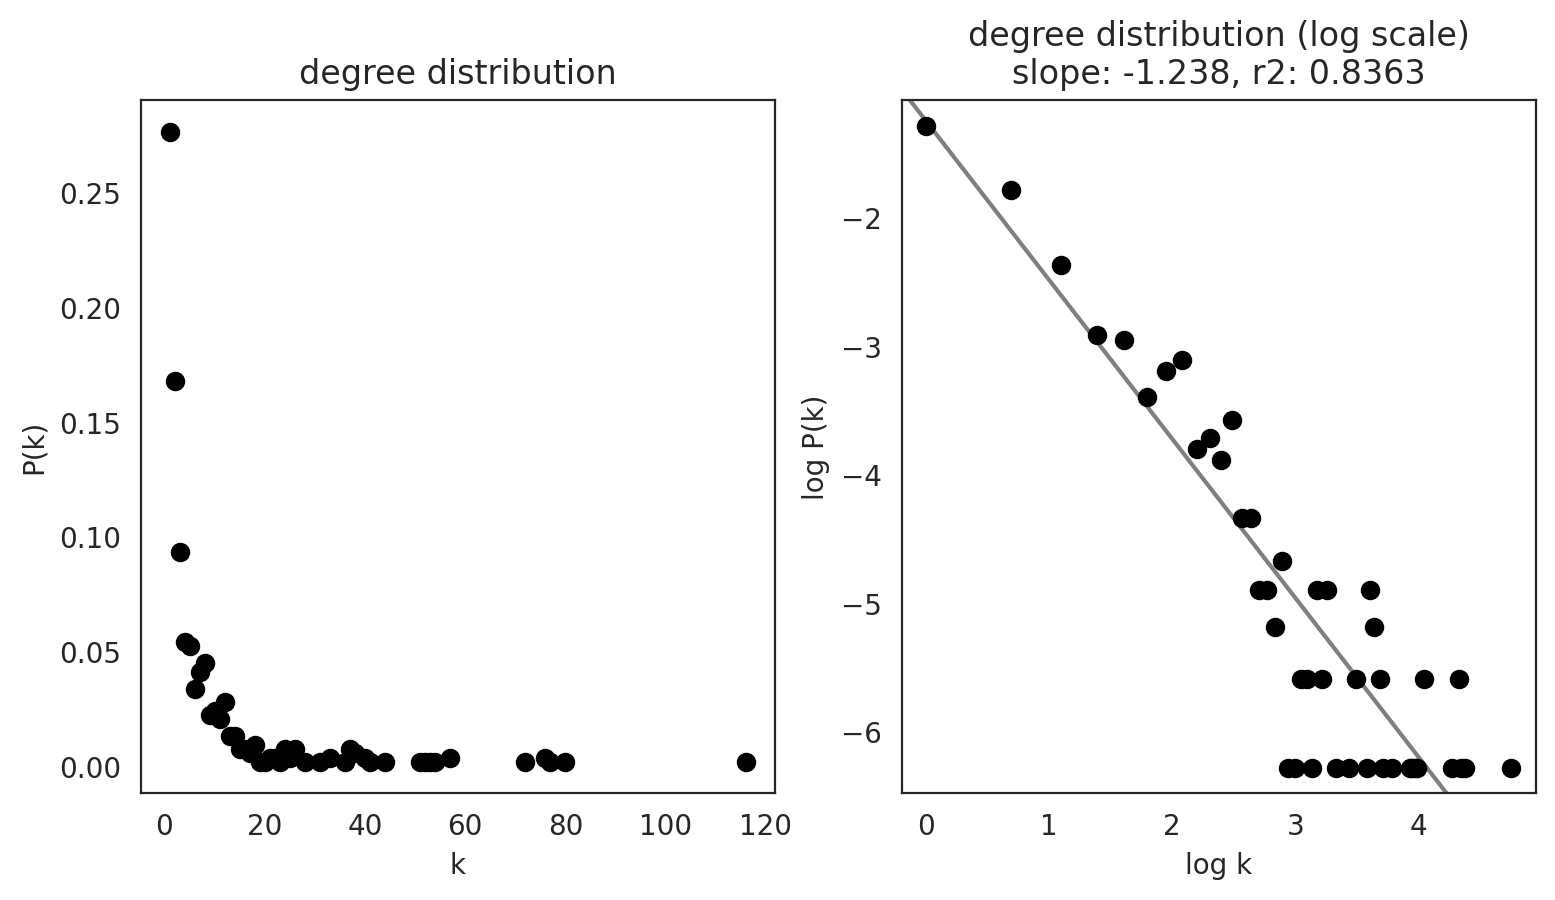


[8] Calculating network scores...
  ✓ Network scores calculated
  ✓ Filtered links saved: celloracle_results/per_celltype/Endothelials_filtered.celloracle.links

[9] Saving gene scores...
  ✓ Saved: celltype_genes/Endothelials/KO_DM_all_genes.csv
  ✓ Saved: celltype_genes/Endothelials/WT_DM_all_genes.csv

[10] Visualizing top genes...
  ✓ Top genes CSV saved

[11] Creating heatmap...
  ✓ Heatmap saved

[12] Score comparison between samples...
  Comparing: KO_DM vs WT_DM


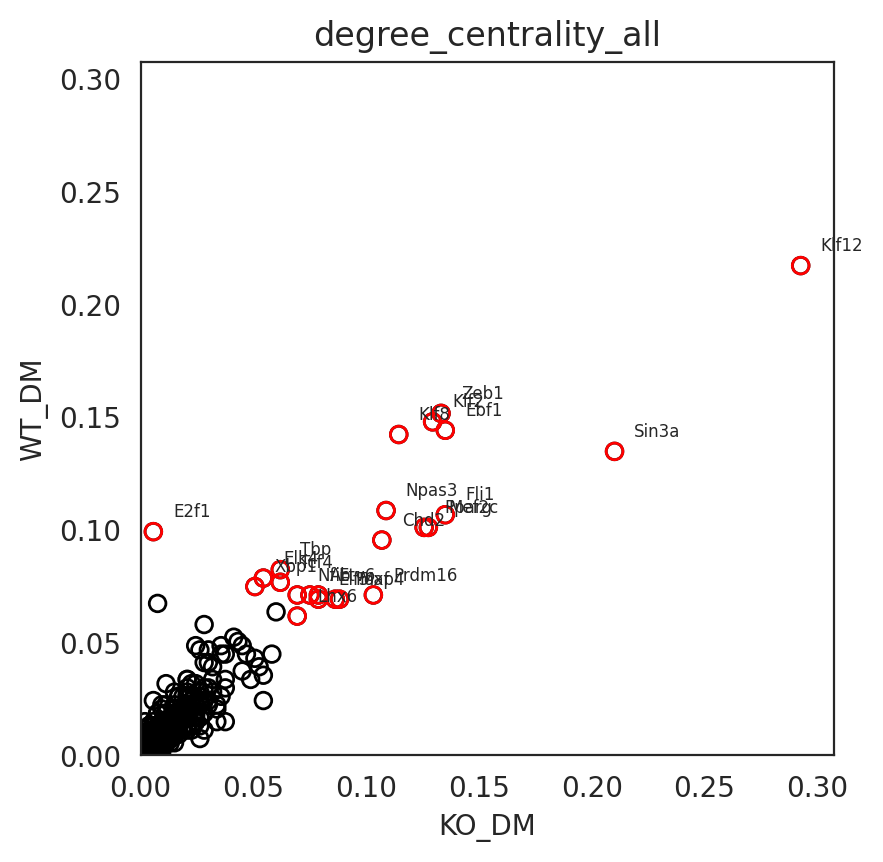

  ✓ Comparison plot saved (symmetrical axes)

  ✓ COMPLETED: Endothelials



>>> [8/14] Starting: Fibroblasts

  Processing: Fibroblasts

[1] Subset: 908 cells x 33696 genes
  Sample distribution:
    WT_DM: 538 cells
    KO_DM: 370 cells

[2] Preprocessing...
  After gene filtering: (908, 19906)
  Selected 2999 highly variable genes
  After HVG selection: (908, 2999)

[3] Computing embeddings...
  ✓ PCA
  ✓ Neighbors (n=30)
  ✓ UMAP

[4] Creating Oracle object...
  ✓ Data imported (cluster_column='sample')
  ✓ TF data imported

[5] KNN imputation...
  PCA components: 132
  Cell count: 908, k: 22
  ✓ KNN imputation complete
  ✓ Oracle saved: celloracle_results/per_celltype/Fibroblasts.celloracle.oracle

[6] GRN calculation (by sample)...


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for KO_DM...


  0%|          | 0/2033 [00:00<?, ?it/s]

Inferring GRN for WT_DM...


  0%|          | 0/2033 [00:00<?, ?it/s]

  ✓ Links saved: celloracle_results/per_celltype/Fibroblasts.celloracle.links

[7] Network preprocessing...
  ✓ Links filtered
KO_DM


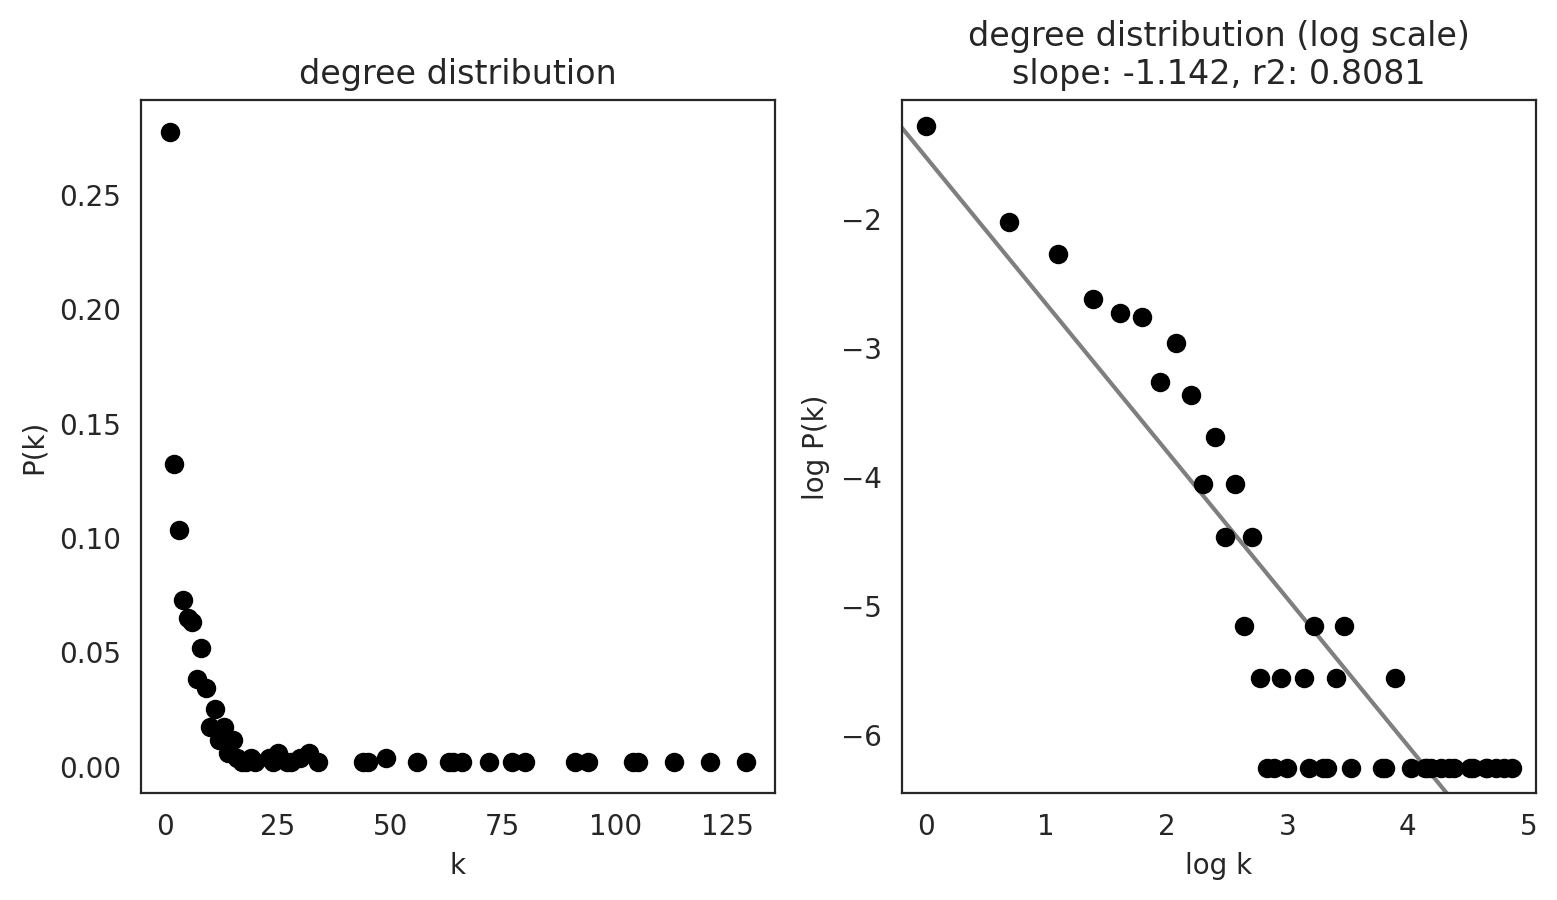

WT_DM


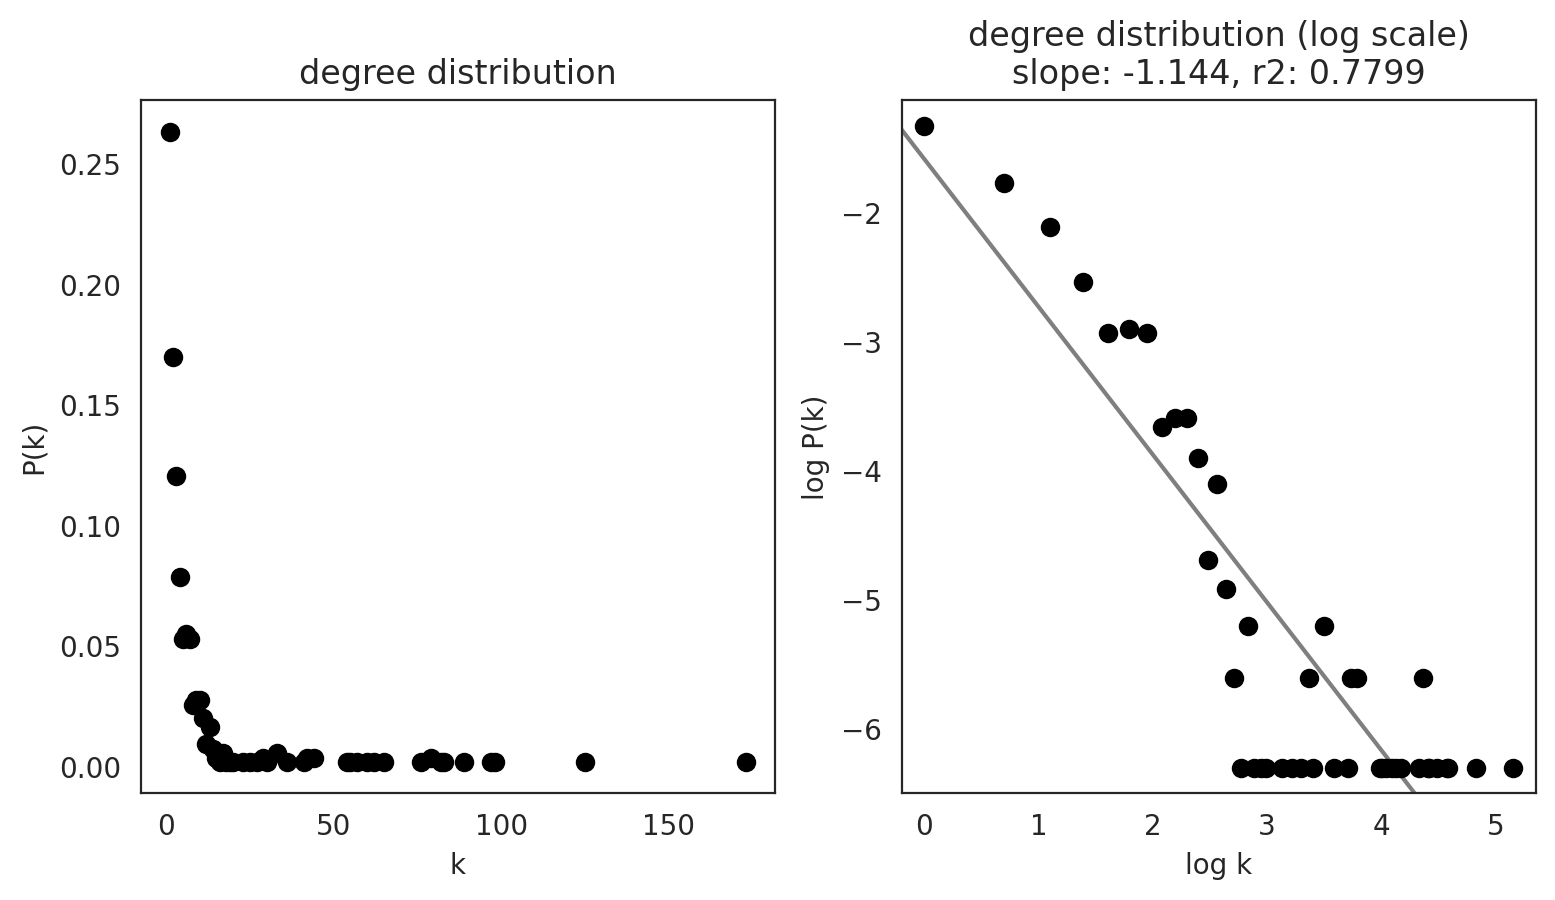


[8] Calculating network scores...
  ✓ Network scores calculated
  ✓ Filtered links saved: celloracle_results/per_celltype/Fibroblasts_filtered.celloracle.links

[9] Saving gene scores...
  ✓ Saved: celltype_genes/Fibroblasts/KO_DM_all_genes.csv
  ✓ Saved: celltype_genes/Fibroblasts/WT_DM_all_genes.csv

[10] Visualizing top genes...
  ✓ Top genes CSV saved

[11] Creating heatmap...
  ✓ Heatmap saved

[12] Score comparison between samples...
  Comparing: KO_DM vs WT_DM


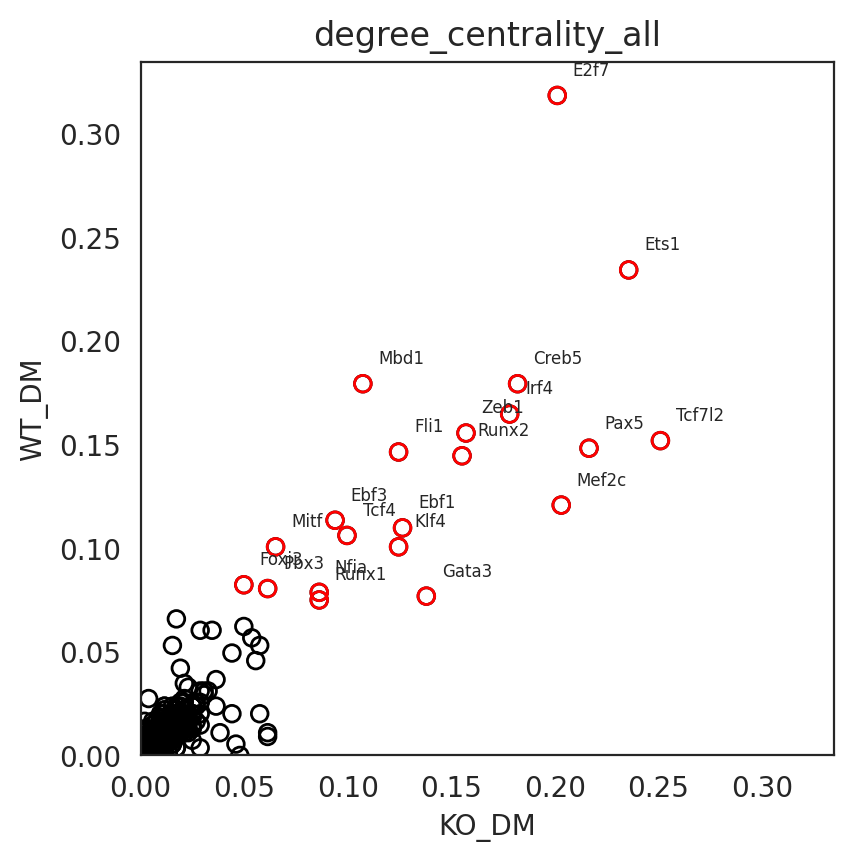

  ✓ Comparison plot saved (symmetrical axes)

  ✓ COMPLETED: Fibroblasts



>>> [9/14] Starting: Tcells

  Processing: Tcells

[1] Subset: 1333 cells x 33696 genes
  Sample distribution:
    KO_DM: 880 cells
    WT_DM: 453 cells

[2] Preprocessing...
  After gene filtering: (1333, 19195)
  Selected 3000 highly variable genes
  After HVG selection: (1333, 3000)

[3] Computing embeddings...
  ✓ PCA
  ✓ Neighbors (n=30)
  ✓ UMAP

[4] Creating Oracle object...
  ✓ Data imported (cluster_column='sample')
  ✓ TF data imported

[5] KNN imputation...
  PCA components: 116
  Cell count: 1333, k: 33
  ✓ KNN imputation complete
  ✓ Oracle saved: celloracle_results/per_celltype/Tcells.celloracle.oracle

[6] GRN calculation (by sample)...


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for KO_DM...


  0%|          | 0/2147 [00:00<?, ?it/s]

Inferring GRN for WT_DM...


  0%|          | 0/2147 [00:00<?, ?it/s]

  ✓ Links saved: celloracle_results/per_celltype/Tcells.celloracle.links

[7] Network preprocessing...
  ✓ Links filtered
KO_DM


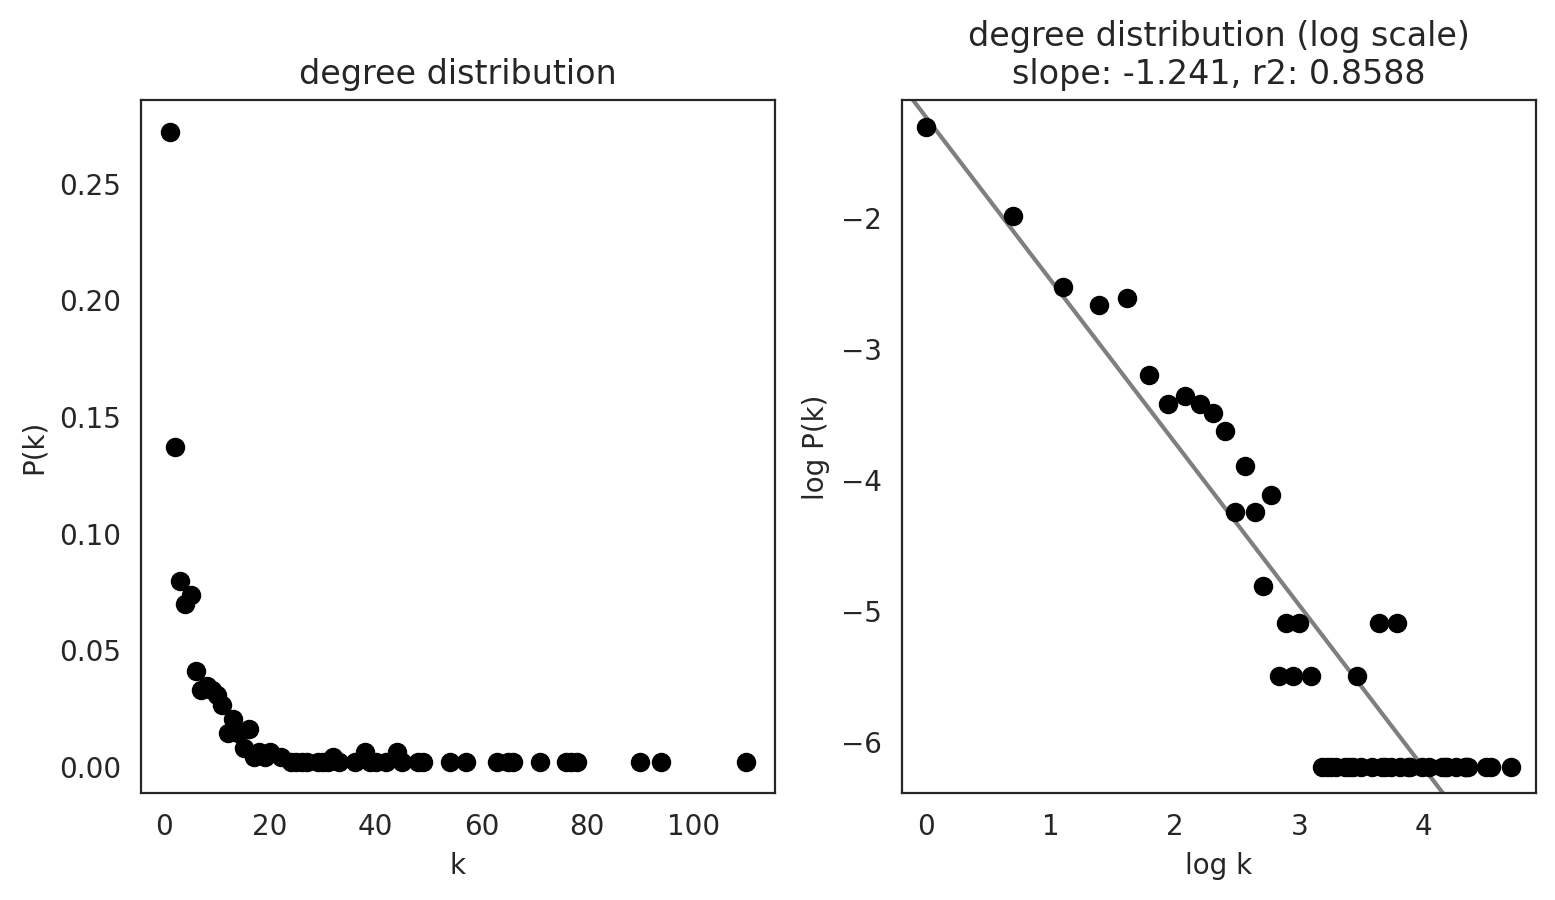

WT_DM


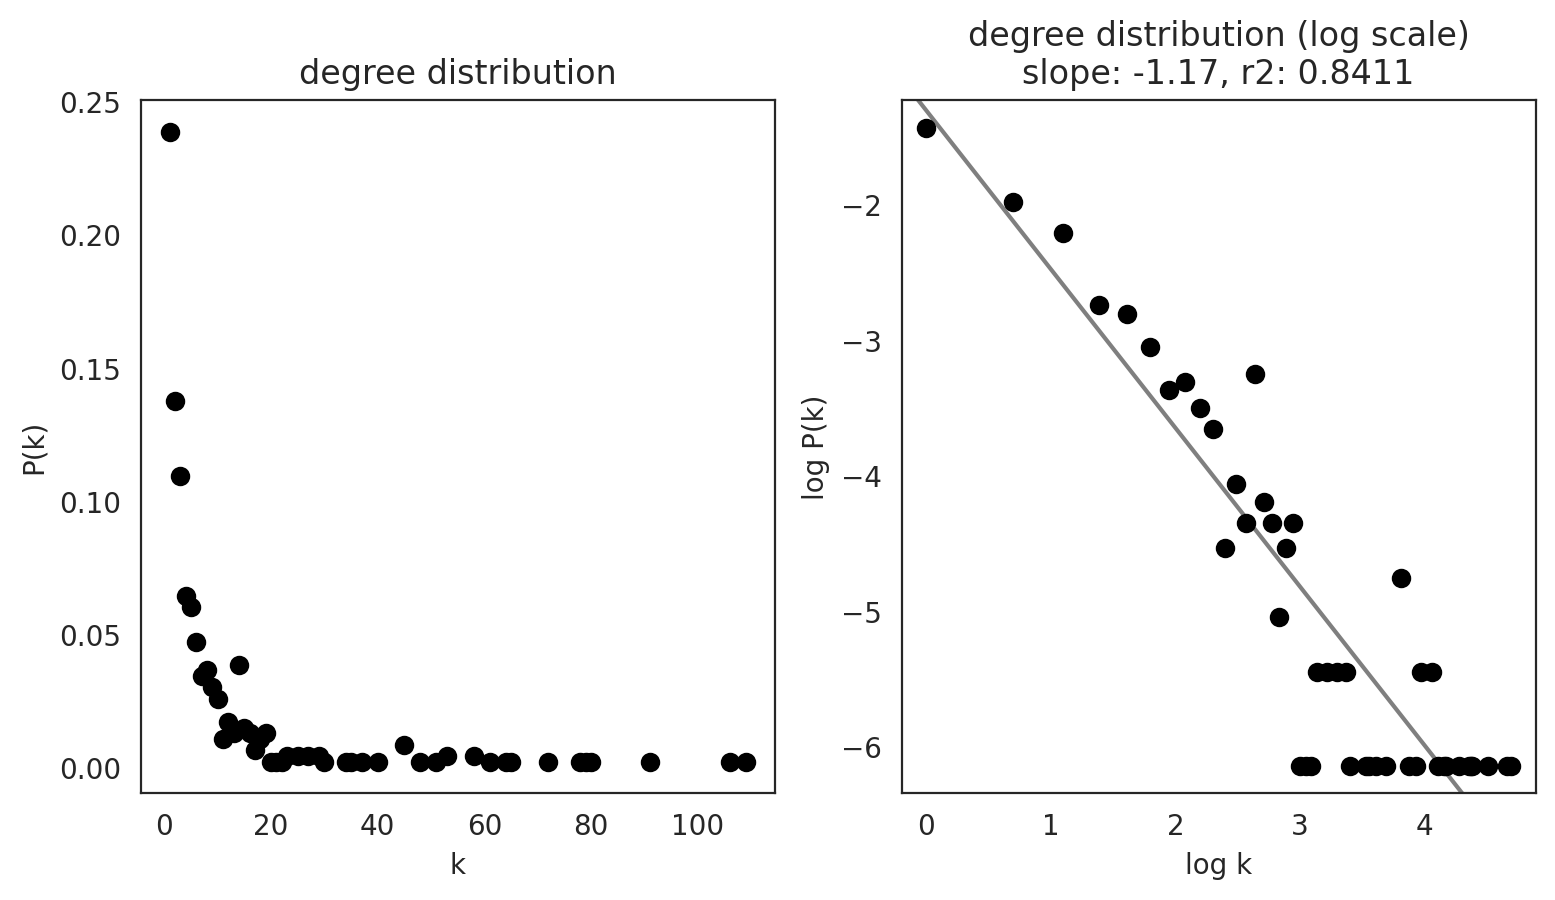


[8] Calculating network scores...
  ✓ Network scores calculated
  ✓ Filtered links saved: celloracle_results/per_celltype/Tcells_filtered.celloracle.links

[9] Saving gene scores...
  ✓ Saved: celltype_genes/Tcells/KO_DM_all_genes.csv
  ✓ Saved: celltype_genes/Tcells/WT_DM_all_genes.csv

[10] Visualizing top genes...
  ✓ Top genes CSV saved

[11] Creating heatmap...
  ✓ Heatmap saved

[12] Score comparison between samples...
  Comparing: KO_DM vs WT_DM


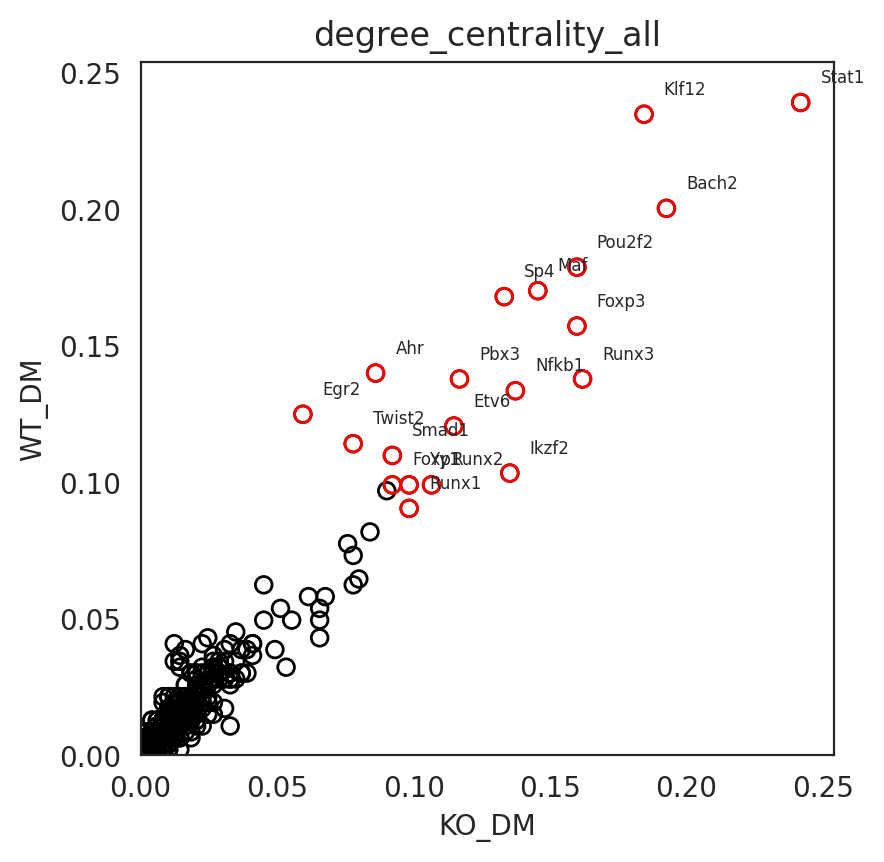

  ✓ Comparison plot saved (symmetrical axes)

  ✓ COMPLETED: Tcells



>>> [10/14] Starting: DCs

  Processing: DCs

[1] Subset: 162 cells x 33696 genes
  Sample distribution:
    KO_DM: 121 cells
    WT_DM: 41 cells

[2] Preprocessing...
  After gene filtering: (162, 16270)
  Selected 2999 highly variable genes
  After HVG selection: (162, 2999)

[3] Computing embeddings...
  ✓ PCA
  ✓ Neighbors (n=30)
  ✓ UMAP

[4] Creating Oracle object...
  ✓ Data imported (cluster_column='sample')
  ✓ TF data imported

[5] KNN imputation...
  PCA components: 150
  Cell count: 162, k: 5
  ✓ KNN imputation complete
  ✓ Oracle saved: celloracle_results/per_celltype/DCs.celloracle.oracle

[6] GRN calculation (by sample)...


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for KO_DM...


  0%|          | 0/2163 [00:00<?, ?it/s]

Inferring GRN for WT_DM...


  0%|          | 0/2163 [00:00<?, ?it/s]

  ✓ Links saved: celloracle_results/per_celltype/DCs.celloracle.links

[7] Network preprocessing...
  ✓ Links filtered
KO_DM


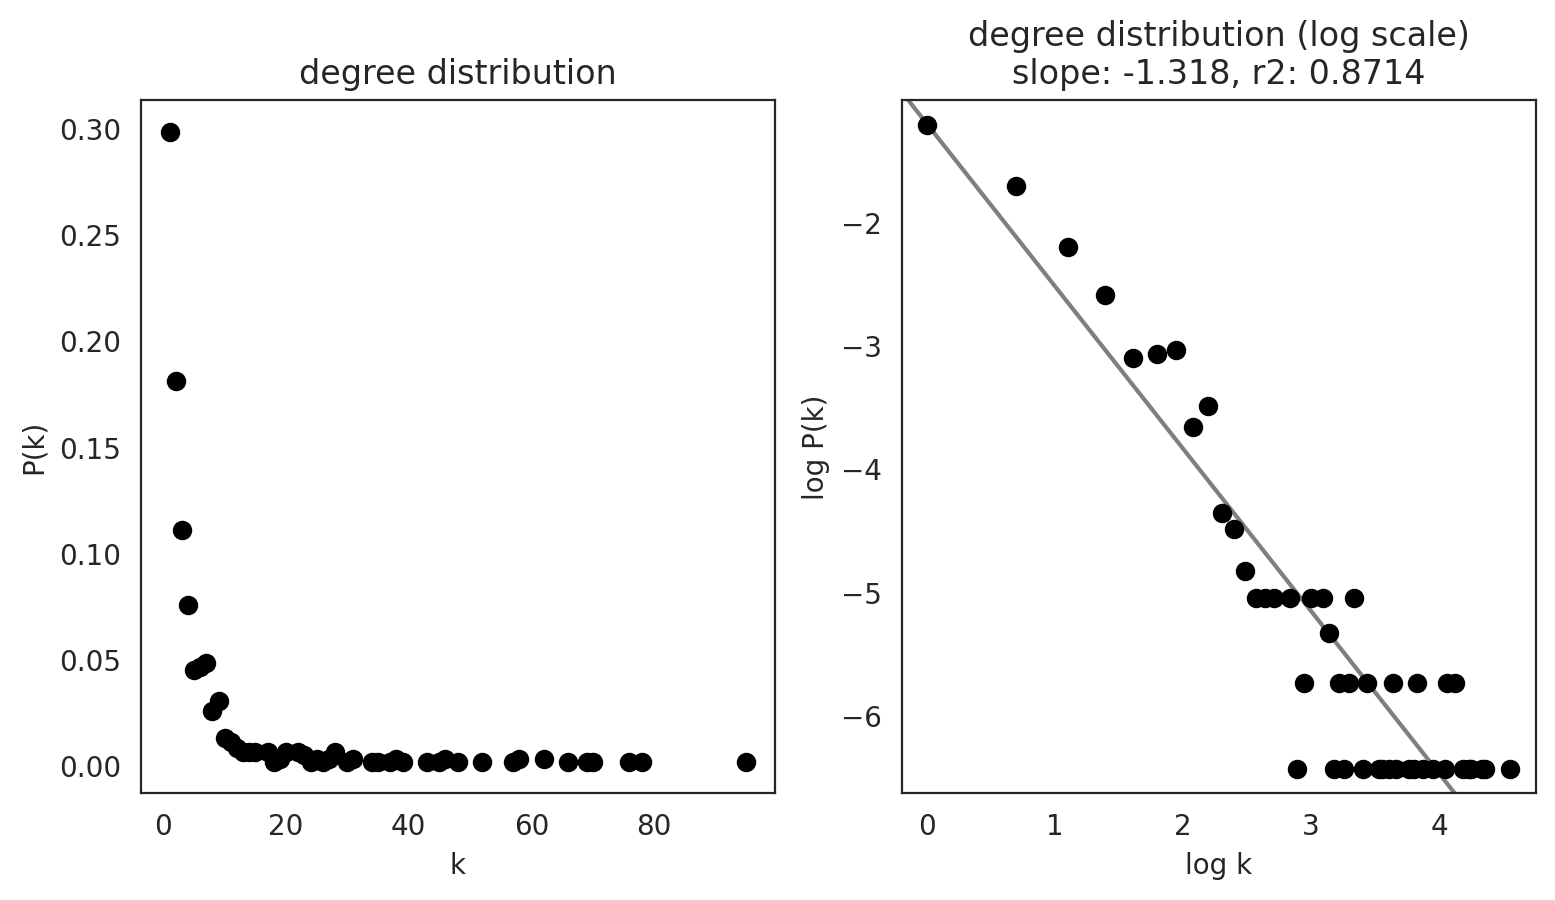

WT_DM


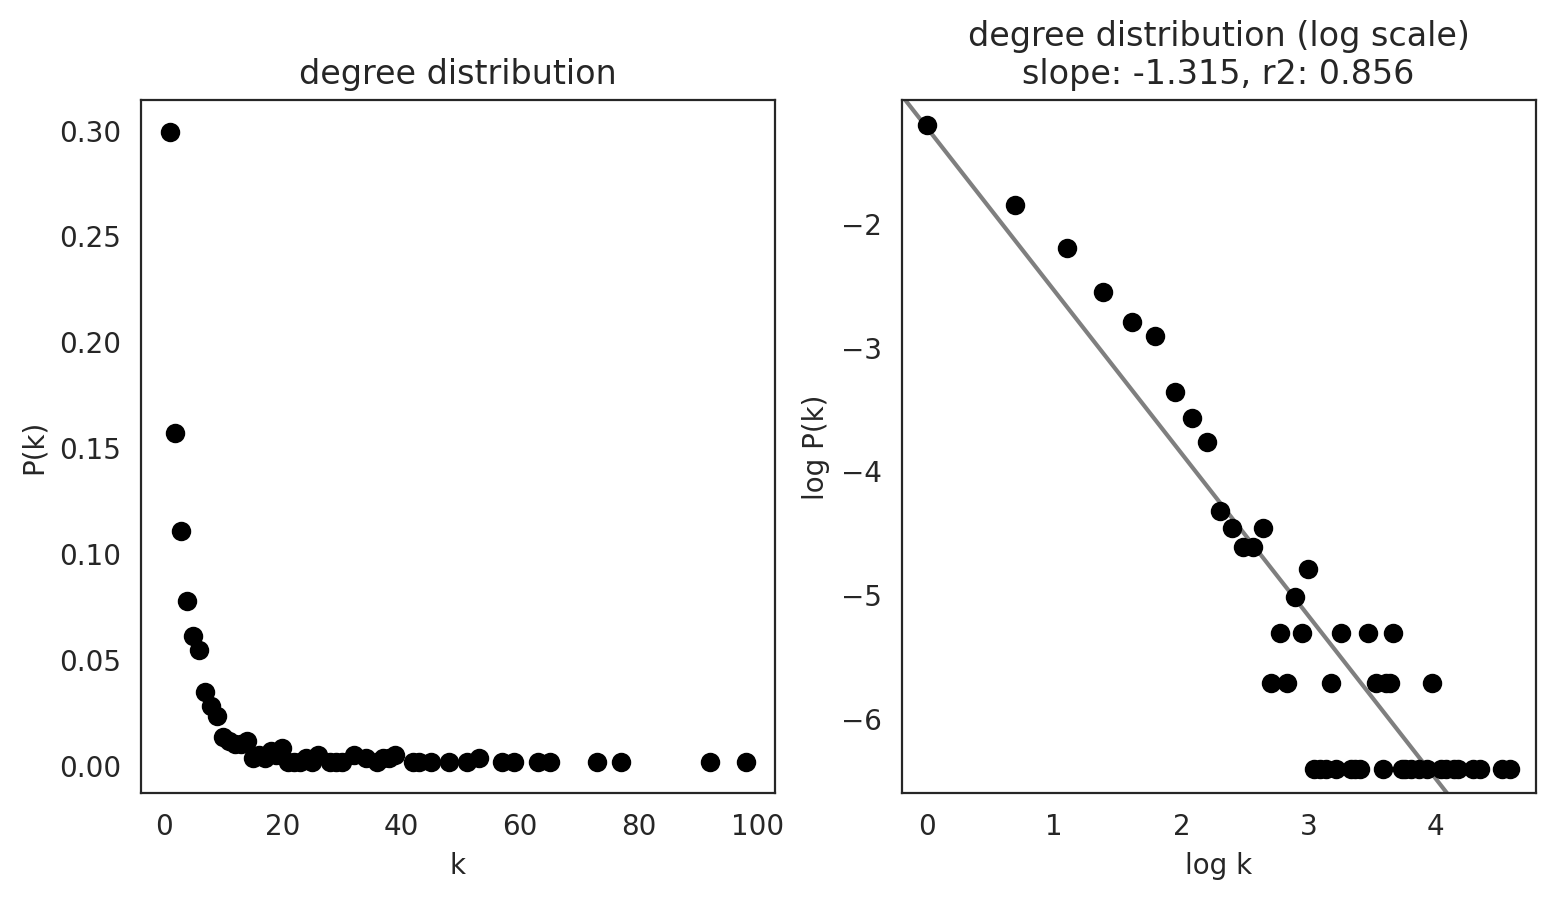


[8] Calculating network scores...
  ✓ Network scores calculated
  ✓ Filtered links saved: celloracle_results/per_celltype/DCs_filtered.celloracle.links

[9] Saving gene scores...
  ✓ Saved: celltype_genes/DCs/KO_DM_all_genes.csv
  ✓ Saved: celltype_genes/DCs/WT_DM_all_genes.csv

[10] Visualizing top genes...
  ✓ Top genes CSV saved

[11] Creating heatmap...
  ✓ Heatmap saved

[12] Score comparison between samples...
  Comparing: KO_DM vs WT_DM


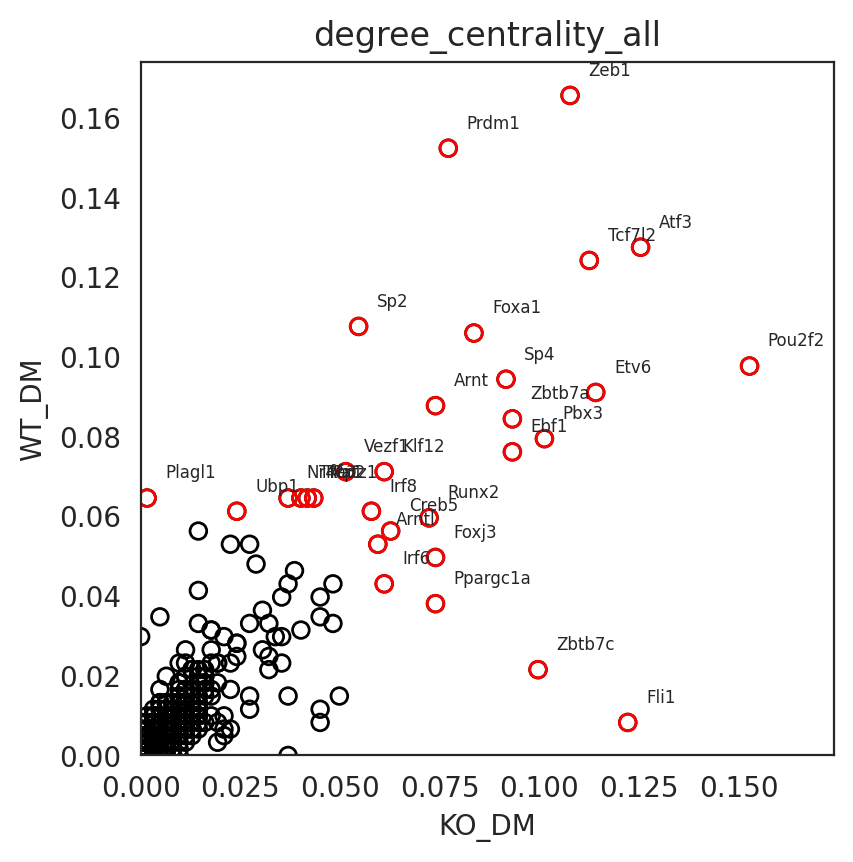

  ✓ Comparison plot saved (symmetrical axes)

  ✓ COMPLETED: DCs



>>> [11/14] Starting: Myeloid_cells

  Processing: Myeloid_cells

[1] Subset: 404 cells x 33696 genes
  Sample distribution:
    KO_DM: 254 cells
    WT_DM: 150 cells

[2] Preprocessing...
  After gene filtering: (404, 17994)
  Selected 3000 highly variable genes
  After HVG selection: (404, 3000)

[3] Computing embeddings...
  ✓ PCA
  ✓ Neighbors (n=30)
  ✓ UMAP

[4] Creating Oracle object...
  ✓ Data imported (cluster_column='sample')
  ✓ TF data imported

[5] KNN imputation...
  PCA components: 171
  Cell count: 404, k: 10
  ✓ KNN imputation complete
  ✓ Oracle saved: celloracle_results/per_celltype/Myeloid_cells.celloracle.oracle

[6] GRN calculation (by sample)...


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for KO_DM...


  0%|          | 0/2166 [00:00<?, ?it/s]

Inferring GRN for WT_DM...


  0%|          | 0/2166 [00:00<?, ?it/s]

  ✓ Links saved: celloracle_results/per_celltype/Myeloid_cells.celloracle.links

[7] Network preprocessing...
  ✓ Links filtered
KO_DM


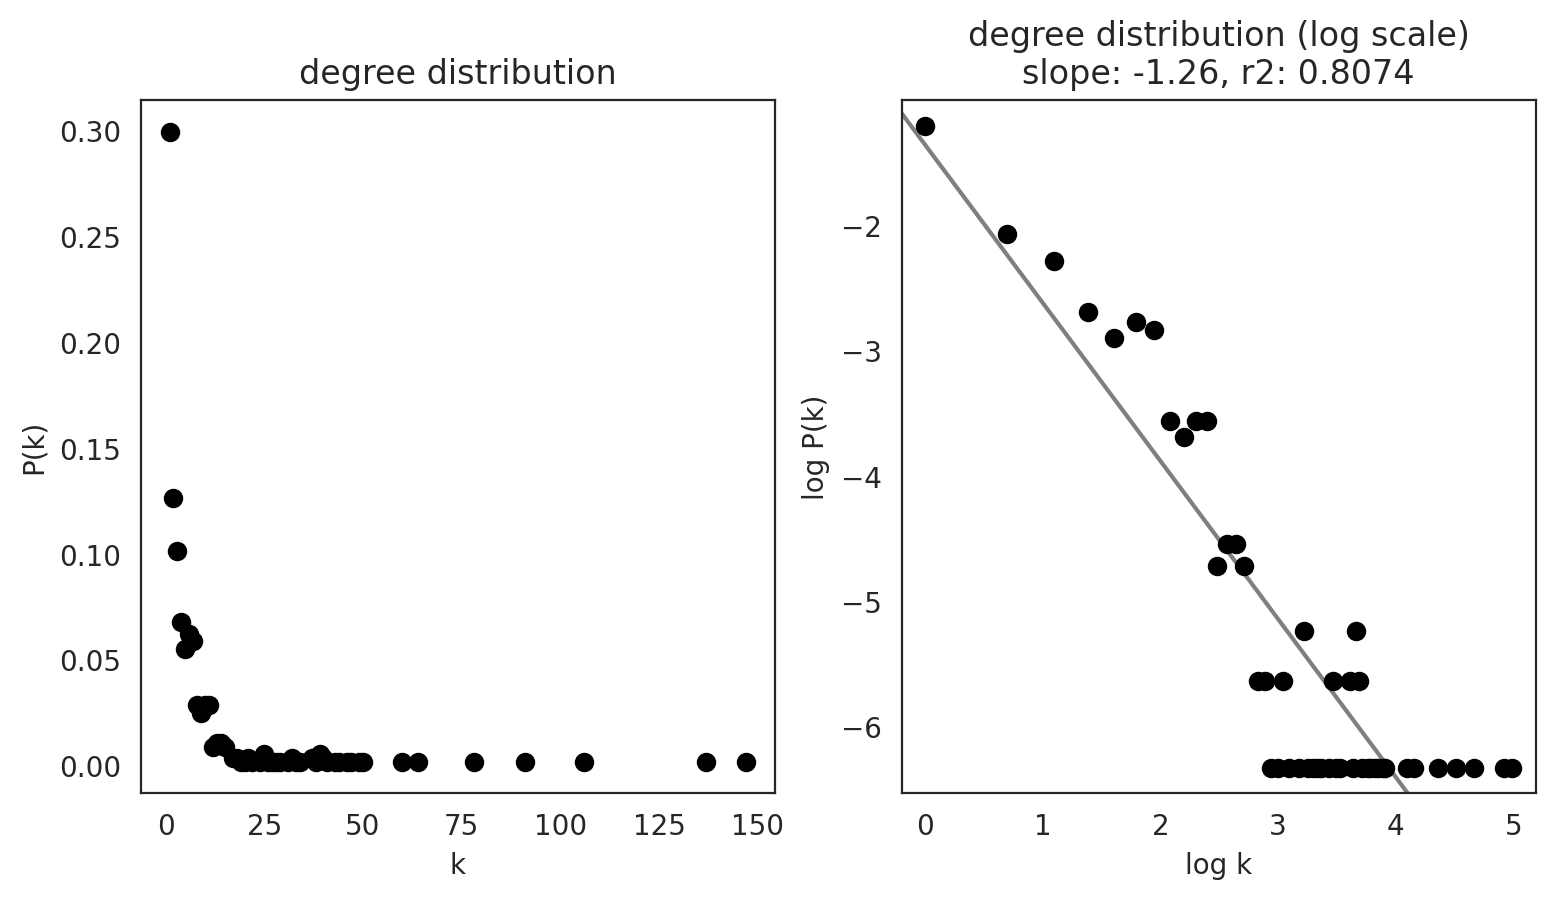

WT_DM


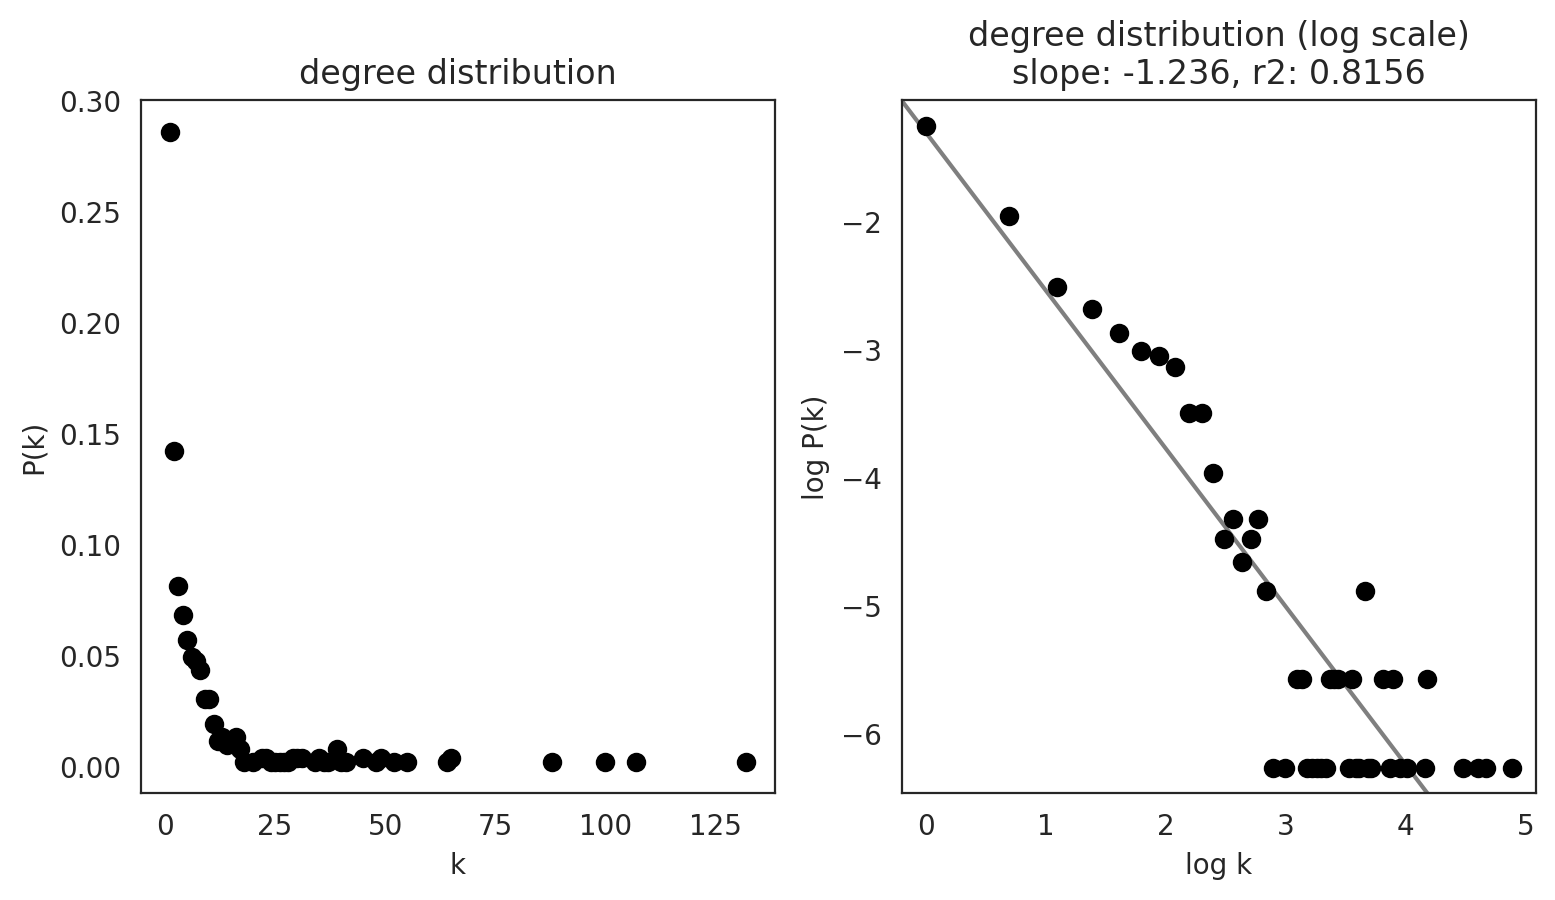


[8] Calculating network scores...
  ✓ Network scores calculated
  ✓ Filtered links saved: celloracle_results/per_celltype/Myeloid_cells_filtered.celloracle.links

[9] Saving gene scores...
  ✓ Saved: celltype_genes/Myeloid_cells/KO_DM_all_genes.csv
  ✓ Saved: celltype_genes/Myeloid_cells/WT_DM_all_genes.csv

[10] Visualizing top genes...
  ✓ Top genes CSV saved

[11] Creating heatmap...
  ✓ Heatmap saved

[12] Score comparison between samples...
  Comparing: KO_DM vs WT_DM


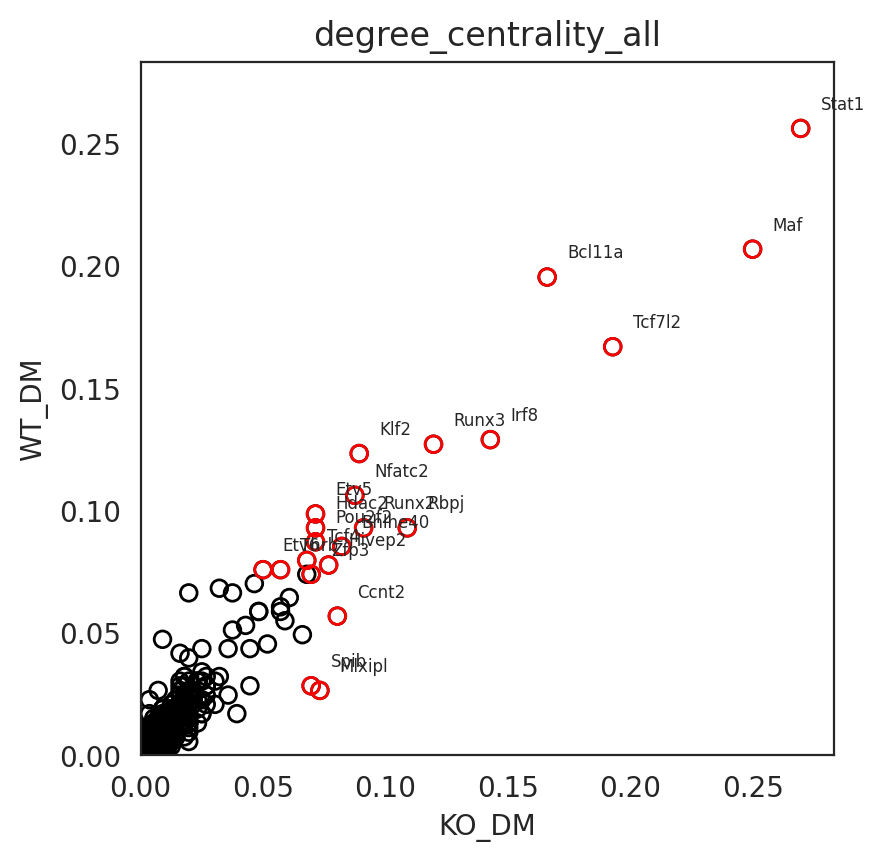

  ✓ Comparison plot saved (symmetrical axes)

  ✓ COMPLETED: Myeloid_cells



>>> [12/14] Starting: Schwann?

  Processing: Schwann?

[1] Subset: 37 cells x 33696 genes
  ⚠ Skipping Schwann?: only 37 cells (min=50)


>>> [13/14] Starting: Epi_proliferating

  Processing: Epi_proliferating

[1] Subset: 221 cells x 33696 genes
  Sample distribution:
    KO_DM: 174 cells
    WT_DM: 47 cells

[2] Preprocessing...
  After gene filtering: (221, 18870)
  Selected 2999 highly variable genes
  After HVG selection: (221, 2999)

[3] Computing embeddings...
  ✓ PCA
  ✓ Neighbors (n=30)
  ✓ UMAP

[4] Creating Oracle object...
  ✓ Data imported (cluster_column='sample')
  ✓ TF data imported

[5] KNN imputation...
  PCA components: 170
  Cell count: 221, k: 5
  ✓ KNN imputation complete
  ✓ Oracle saved: celloracle_results/per_celltype/Epi_proliferating.celloracle.oracle

[6] GRN calculation (by sample)...


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for KO_DM...


  0%|          | 0/2131 [00:00<?, ?it/s]

Inferring GRN for WT_DM...


  0%|          | 0/2131 [00:00<?, ?it/s]

  ✓ Links saved: celloracle_results/per_celltype/Epi_proliferating.celloracle.links

[7] Network preprocessing...
  ✓ Links filtered
KO_DM


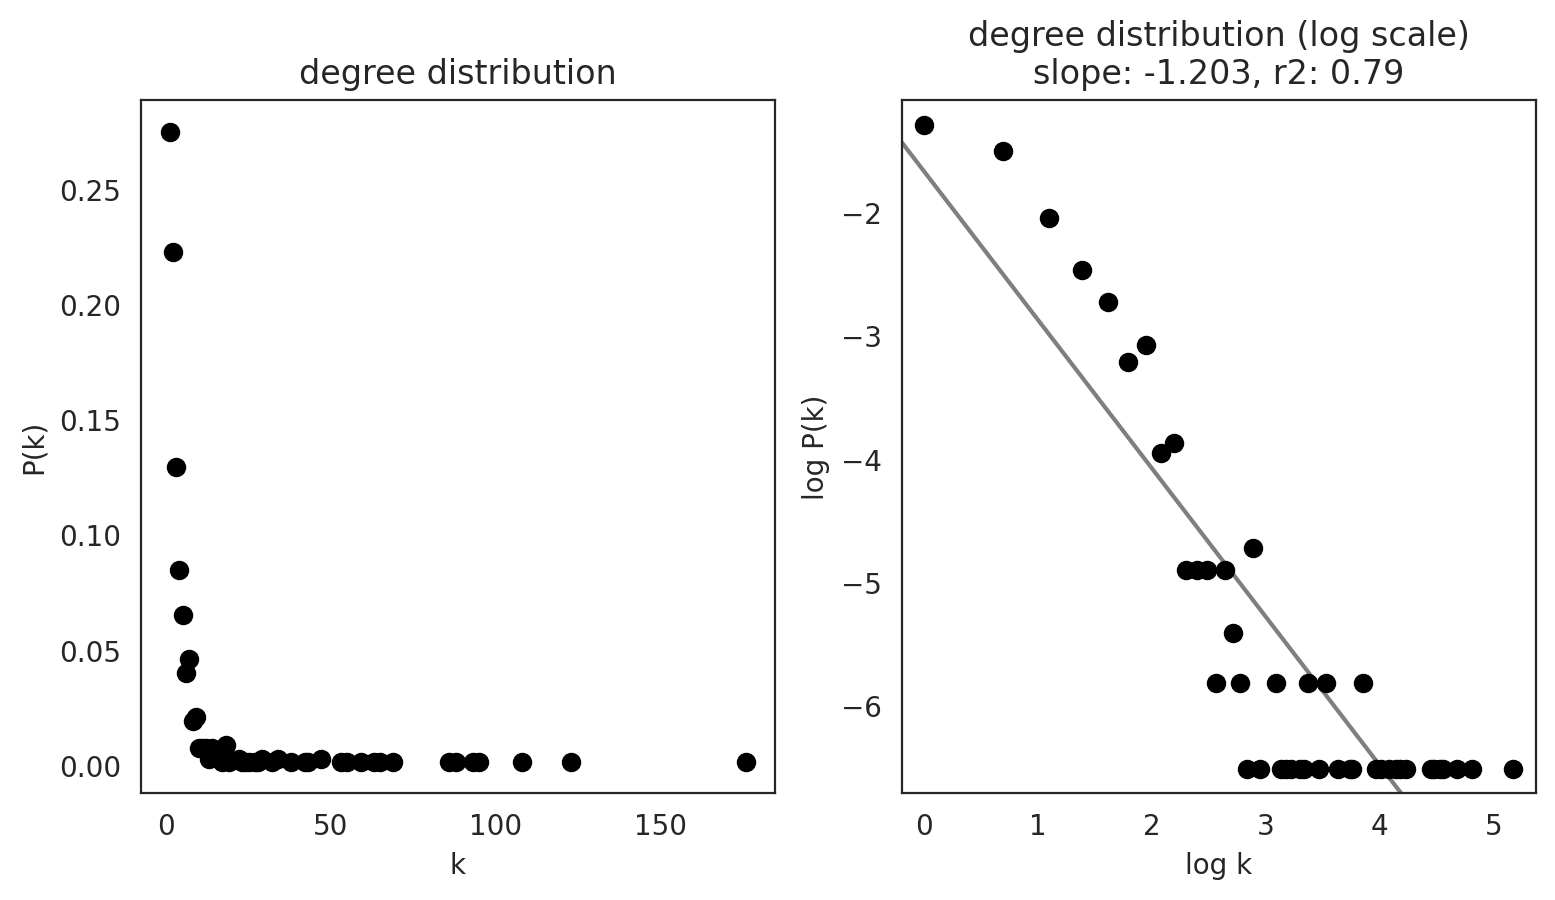

WT_DM


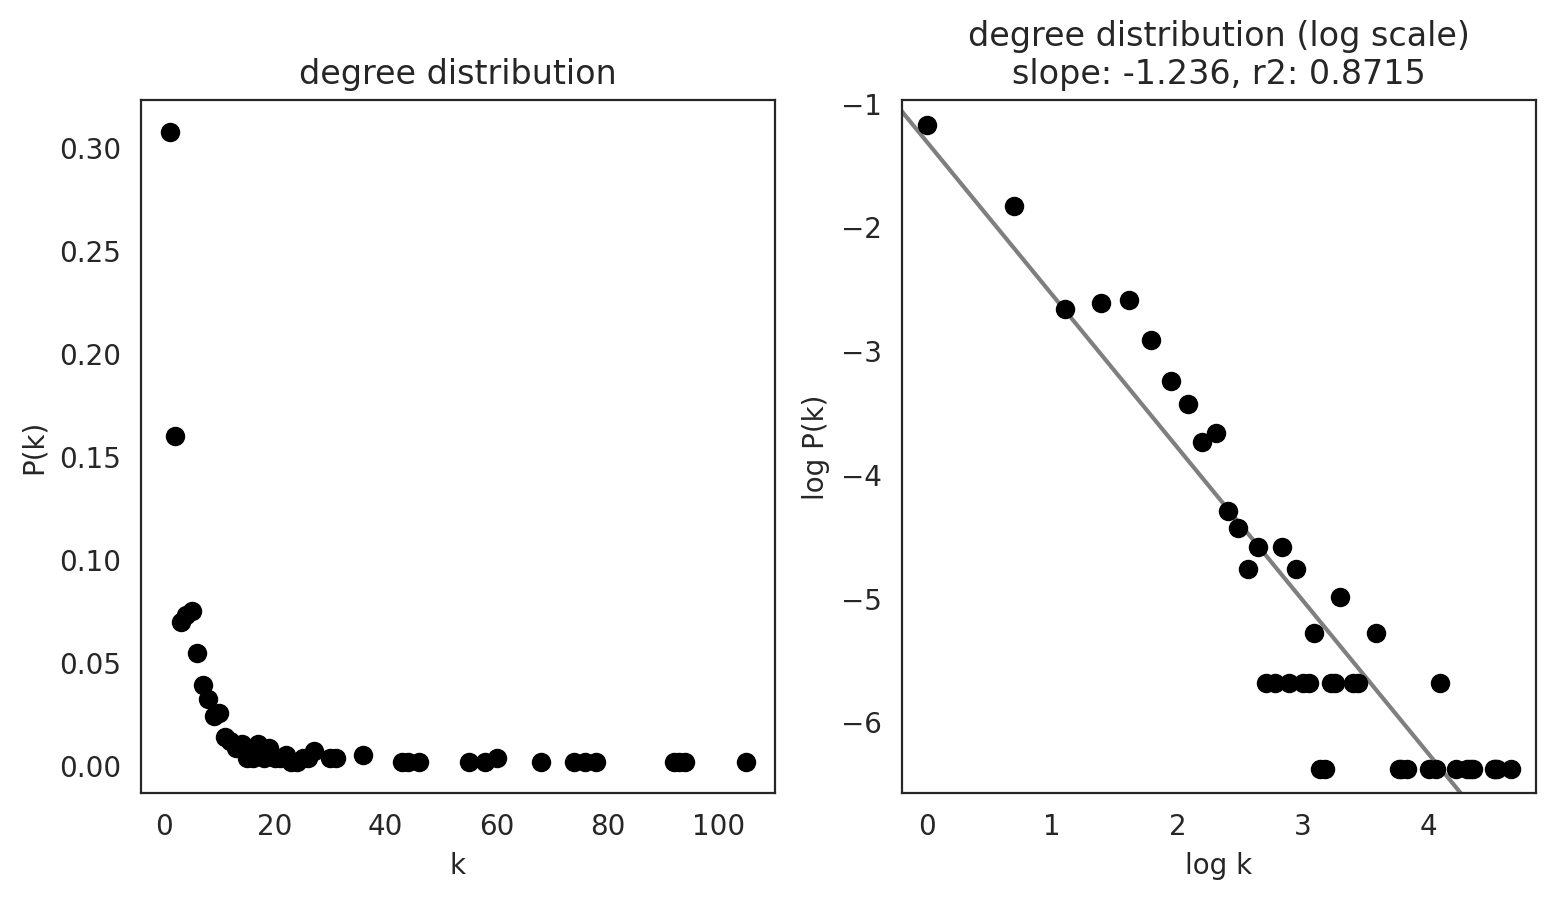


[8] Calculating network scores...
  ✓ Network scores calculated
  ✓ Filtered links saved: celloracle_results/per_celltype/Epi_proliferating_filtered.celloracle.links

[9] Saving gene scores...
  ✓ Saved: celltype_genes/Epi_proliferating/KO_DM_all_genes.csv
  ✓ Saved: celltype_genes/Epi_proliferating/WT_DM_all_genes.csv

[10] Visualizing top genes...
  ✓ Top genes CSV saved

[11] Creating heatmap...
  ✓ Heatmap saved

[12] Score comparison between samples...
  Comparing: KO_DM vs WT_DM


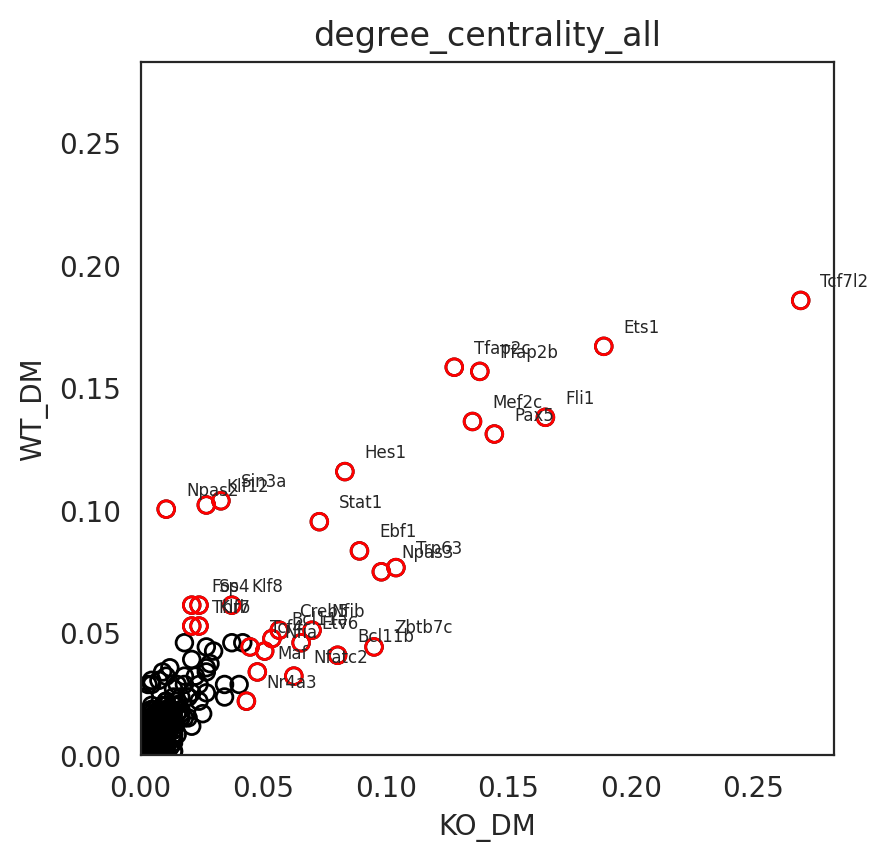

  ✓ Comparison plot saved (symmetrical axes)

  ✓ COMPLETED: Epi_proliferating



>>> [14/14] Starting: SMC?

  Processing: SMC?

[1] Subset: 79 cells x 33696 genes
  Sample distribution:
    KO_DM: 63 cells
    WT_DM: 16 cells

[2] Preprocessing...
  After gene filtering: (79, 15221)
  Selected 3117 highly variable genes
  After HVG selection: (79, 3117)

[3] Computing embeddings...
  ✓ PCA
  ✓ Neighbors (n=30)
  ✓ UMAP

[4] Creating Oracle object...
  ✓ Data imported (cluster_column='sample')
  ✓ TF data imported

[5] KNN imputation...
  PCA components: 76
  Cell count: 79, k: 5
  ✓ KNN imputation complete
  ✓ Oracle saved: celloracle_results/per_celltype/SMC?.celloracle.oracle

[6] GRN calculation (by sample)...


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for KO_DM...


  0%|          | 0/2297 [00:00<?, ?it/s]

Inferring GRN for WT_DM...


  0%|          | 0/2297 [00:00<?, ?it/s]

  ✓ Links saved: celloracle_results/per_celltype/SMC?.celloracle.links

[7] Network preprocessing...
  ✓ Links filtered
KO_DM


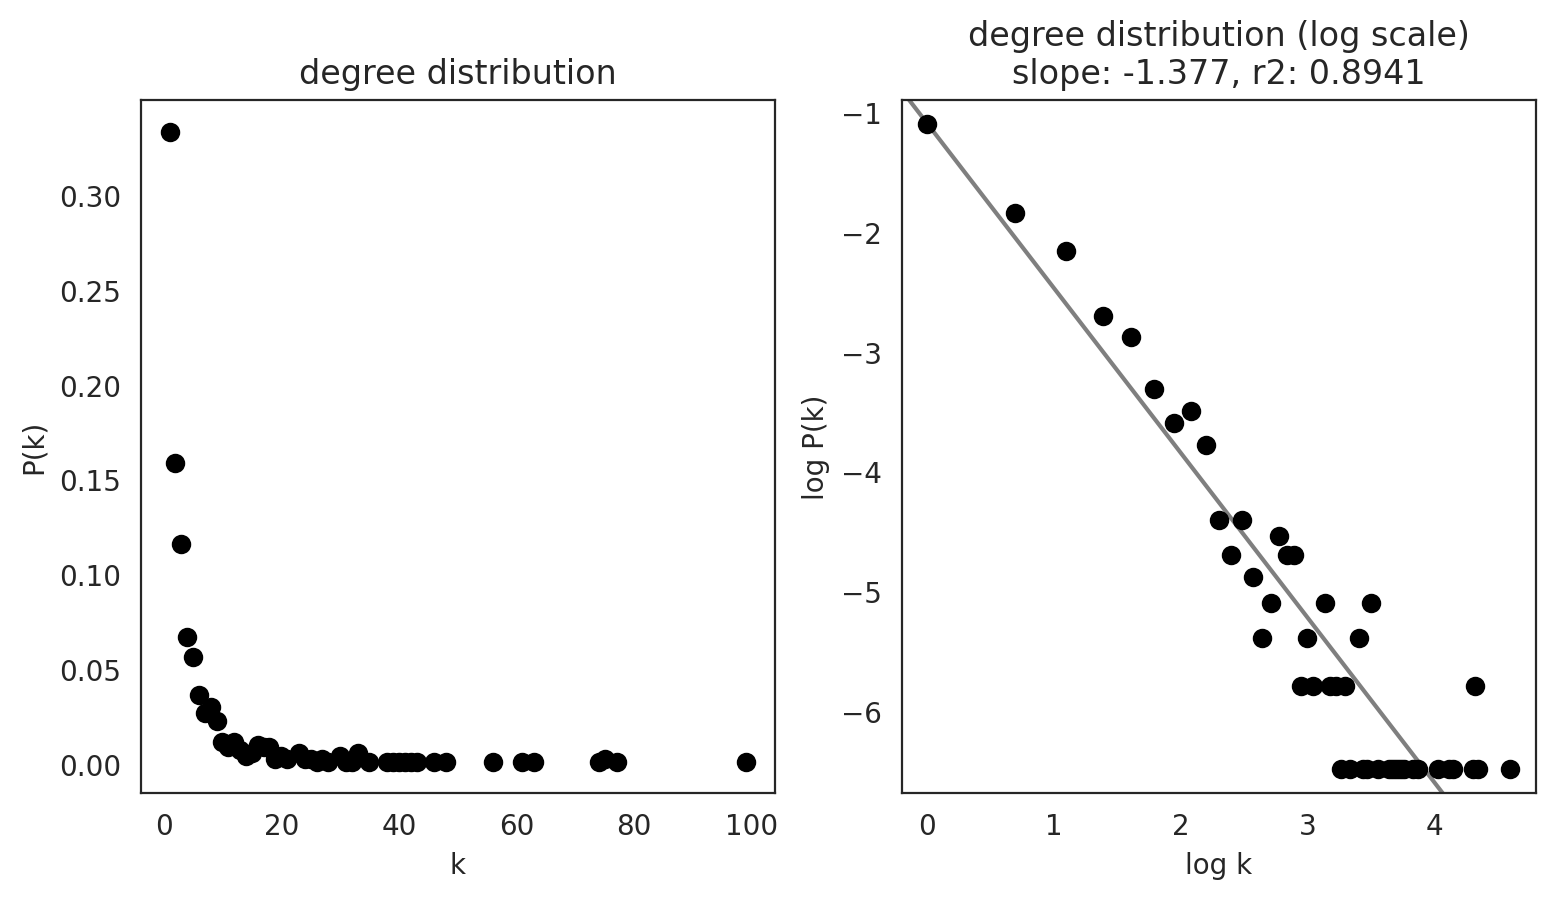

WT_DM


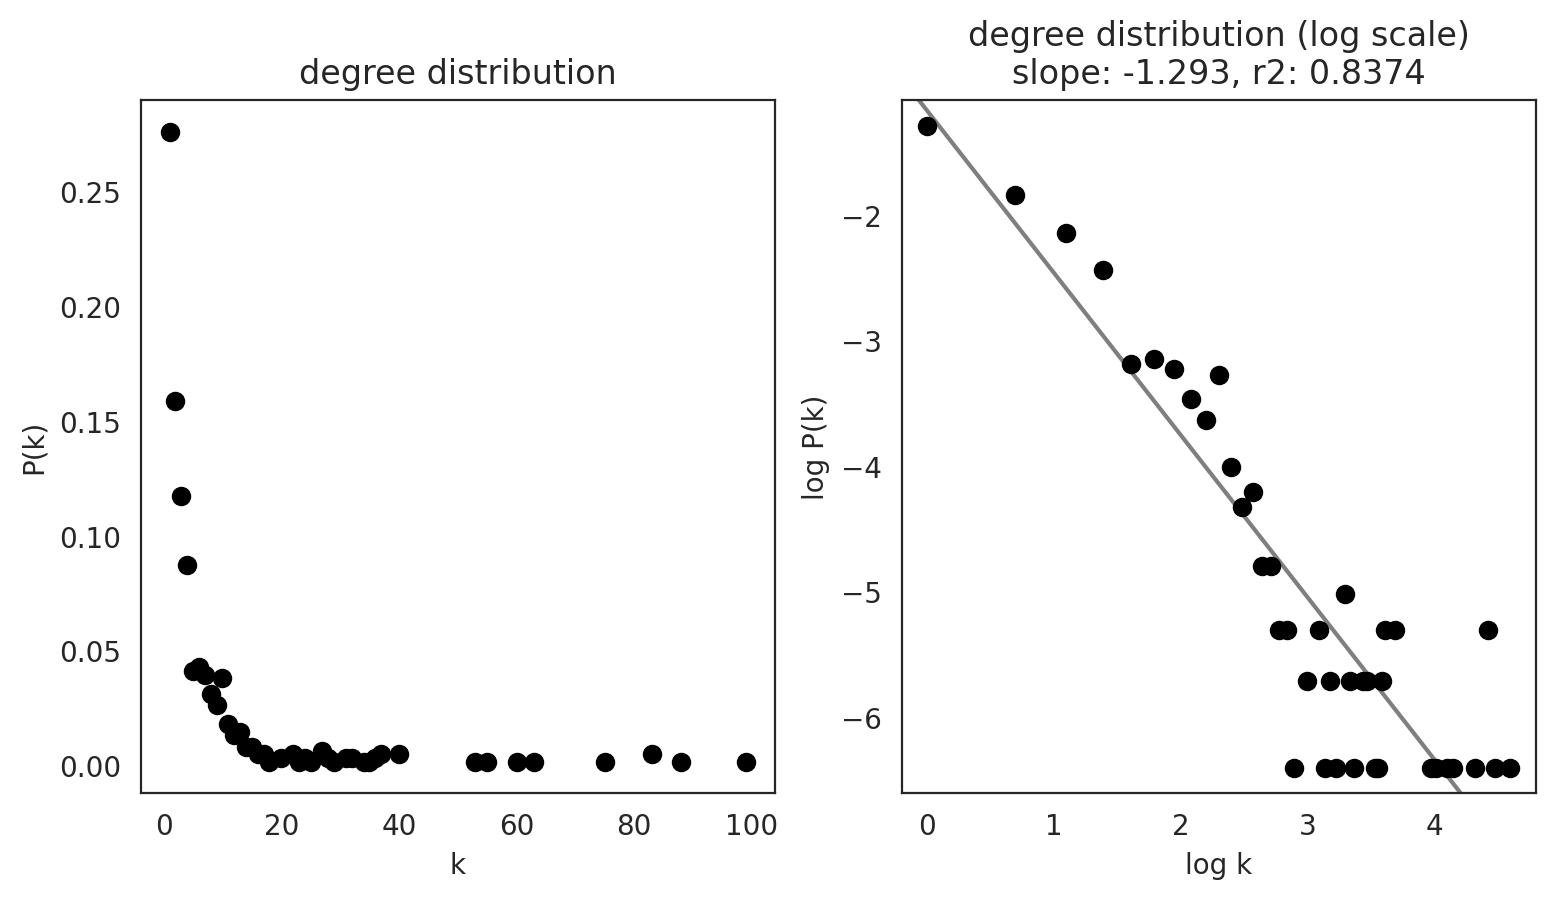


[8] Calculating network scores...
  ✓ Network scores calculated
  ✓ Filtered links saved: celloracle_results/per_celltype/SMC?_filtered.celloracle.links

[9] Saving gene scores...
  ✓ Saved: celltype_genes/SMC?/KO_DM_all_genes.csv
  ✓ Saved: celltype_genes/SMC?/WT_DM_all_genes.csv

[10] Visualizing top genes...
  ✓ Top genes CSV saved

[11] Creating heatmap...
  ✓ Heatmap saved

[12] Score comparison between samples...
  Comparing: KO_DM vs WT_DM


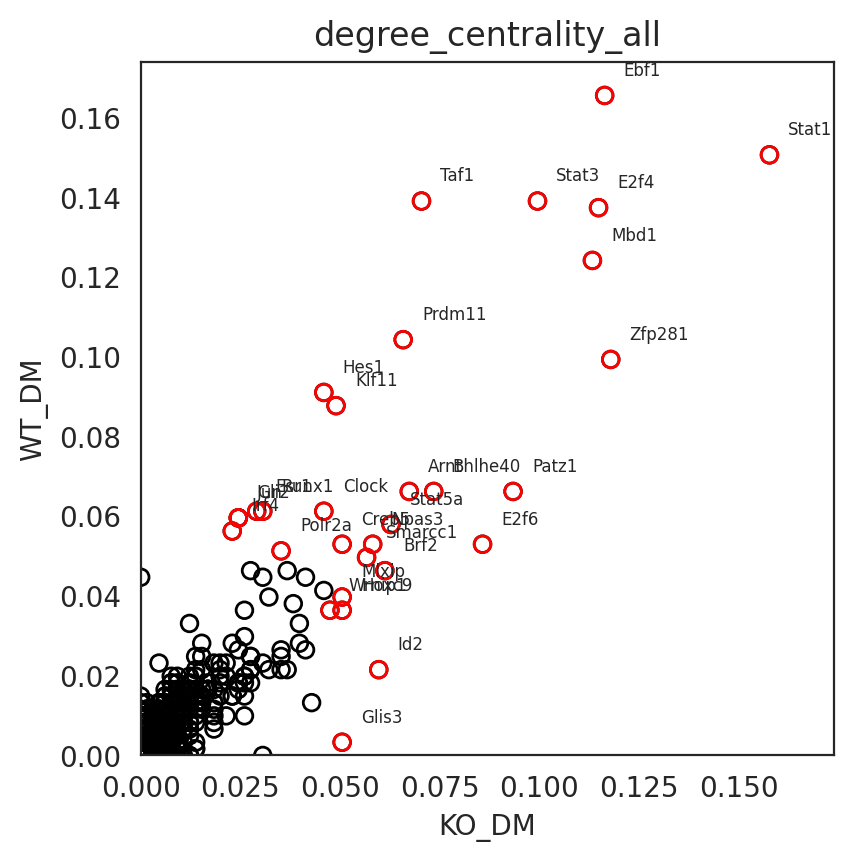

  ✓ Comparison plot saved (symmetrical axes)

  ✓ COMPLETED: SMC?



SUMMARY
Successfully processed: 13/14
  Completed: ['Epi_Kit+Elf5+', 'Epi_Ctr9+', 'Bcells', 'Pericytes/SMC', 'BasalEpi_Acta2+Trp63', 'Adipocyte', 'Endothelials', 'Fibroblasts', 'Tcells', 'DCs', 'Myeloid_cells', 'Epi_proliferating', 'SMC?']
  Skipped/Failed: ['Schwann?']


In [19]:
# Store results for all cell types
results = {}
skipped = []

for i, cell_type in enumerate(cell_types):
    print(f"\n\n>>> [{i+1}/{len(cell_types)}] Starting: {cell_type}")
    
    try:
        oracle, links = run_celloracle_for_celltype(
            adata_full=adata_full,
            cell_type=cell_type,
            base_GRN=base_GRN,
            base_results=base_results,
            base_figures=base_figures,
            base_genes=base_genes,
            min_cells=50,
            n_top_genes=3000
        )
        
        if oracle is not None:
            results[cell_type] = {'oracle': oracle, 'links': links}
        else:
            skipped.append(cell_type)
            
    except Exception as e:
        print(f"\n  ✗ ERROR processing {cell_type}: {e}")
        import traceback
        traceback.print_exc()
        skipped.append(cell_type)

print(f"\n\n{'='*70}")
print(f"SUMMARY")
print(f"{'='*70}")
print(f"Successfully processed: {len(results)}/{len(cell_types)}")
print(f"  Completed: {list(results.keys())}")
if skipped:
    print(f"  Skipped/Failed: {skipped}")

## 5. Cross-cell-type summary

In [20]:
# Create a combined summary of top degree centrality genes across all cell types and samples
all_summaries = []

for cell_type, res in results.items():
    links = res['links']
    for sample_name in links.cluster:
        df = links.merged_score[links.merged_score['cluster'] == sample_name].copy()
        df_top = df.sort_values('degree_centrality_all', ascending=False).head(20)
        df_top = df_top[['degree_centrality_all']].copy()
        df_top['cell_type'] = cell_type
        df_top['sample'] = sample_name
        df_top['gene'] = df_top.index
        df_top['rank'] = range(1, len(df_top) + 1)
        all_summaries.append(df_top)

if all_summaries:
    summary_df = pd.concat(all_summaries, ignore_index=True)
    summary_df = summary_df[['cell_type', 'sample', 'rank', 'gene', 'degree_centrality_all']]
    summary_df.to_csv(f"{base_genes}/cross_celltype_top20_summary.csv", index=False)
    print(f"\u2713 Cross-cell-type summary saved")
    print(f"  Shape: {summary_df.shape}")
    display(summary_df.head(20))
else:
    print("No results to summarize")

✓ Cross-cell-type summary saved
  Shape: (520, 5)


cell_type sample  rank    gene  degree_centrality_all
0   Epi_Kit+Elf5+  KO_DM     1  Tfap2b               0.384615
1   Epi_Kit+Elf5+  KO_DM     2  Tcf7l2               0.353480
2   Epi_Kit+Elf5+  KO_DM     3    Xbp1               0.144689
3   Epi_Kit+Elf5+  KO_DM     4    Etv6               0.141026
4   Epi_Kit+Elf5+  KO_DM     5    Hes1               0.130037
5   Epi_Kit+Elf5+  KO_DM     6  Zbtb7c               0.128205
6   Epi_Kit+Elf5+  KO_DM     7   Plag1               0.122711
7   Epi_Kit+Elf5+  KO_DM     8    Rora               0.120879
8   Epi_Kit+Elf5+  KO_DM     9   Npas3               0.117216
9   Epi_Kit+Elf5+  KO_DM    10    Jund               0.113553
10  Epi_Kit+Elf5+  KO_DM    11    Nfib               0.111722
11  Epi_Kit+Elf5+  KO_DM    12   Creb5               0.108059
12  Epi_Kit+Elf5+  KO_DM    13     Ehf               0.100733
13  Epi_Kit+Elf5+  KO_DM    14   Nr3c2               0.091575
14  Epi_Kit+Elf5+  KO_DM    15     Ahr               0.086081
15  Epi_Kit+Elf5+  KO_DM    16    Thrb               0.076923
16  Epi_Kit+Elf5+  KO_DM    17    Pbx1               0.075092
17  Epi_Kit+Elf5+  KO_DM    18  Polr2a               0.073260
18  Epi_Kit+Elf5+  KO_DM    19   Foxp1               0.071429
19  Epi_Kit+Elf5+  KO_DM    20   Runx1               0.067766

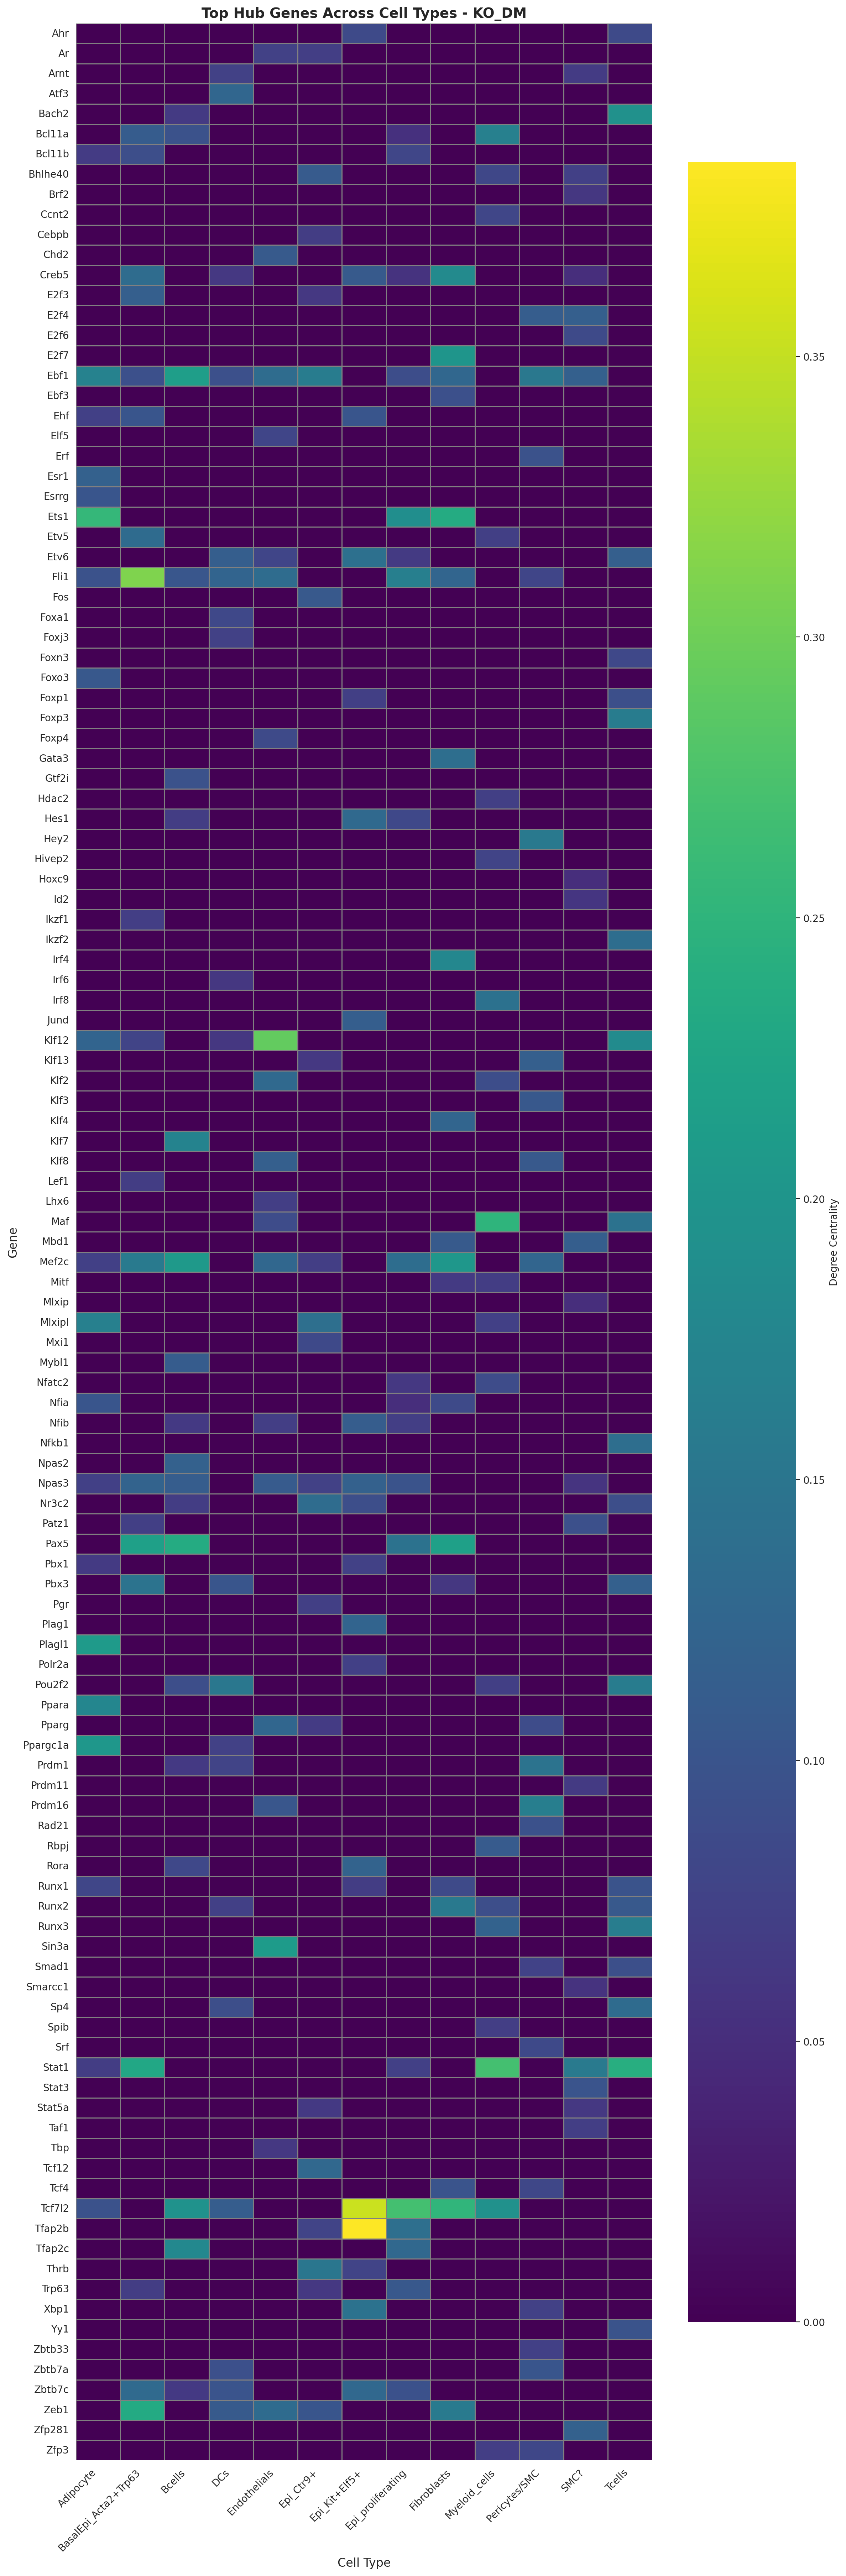

✓ Cross-cell-type heatmap saved for KO_DM


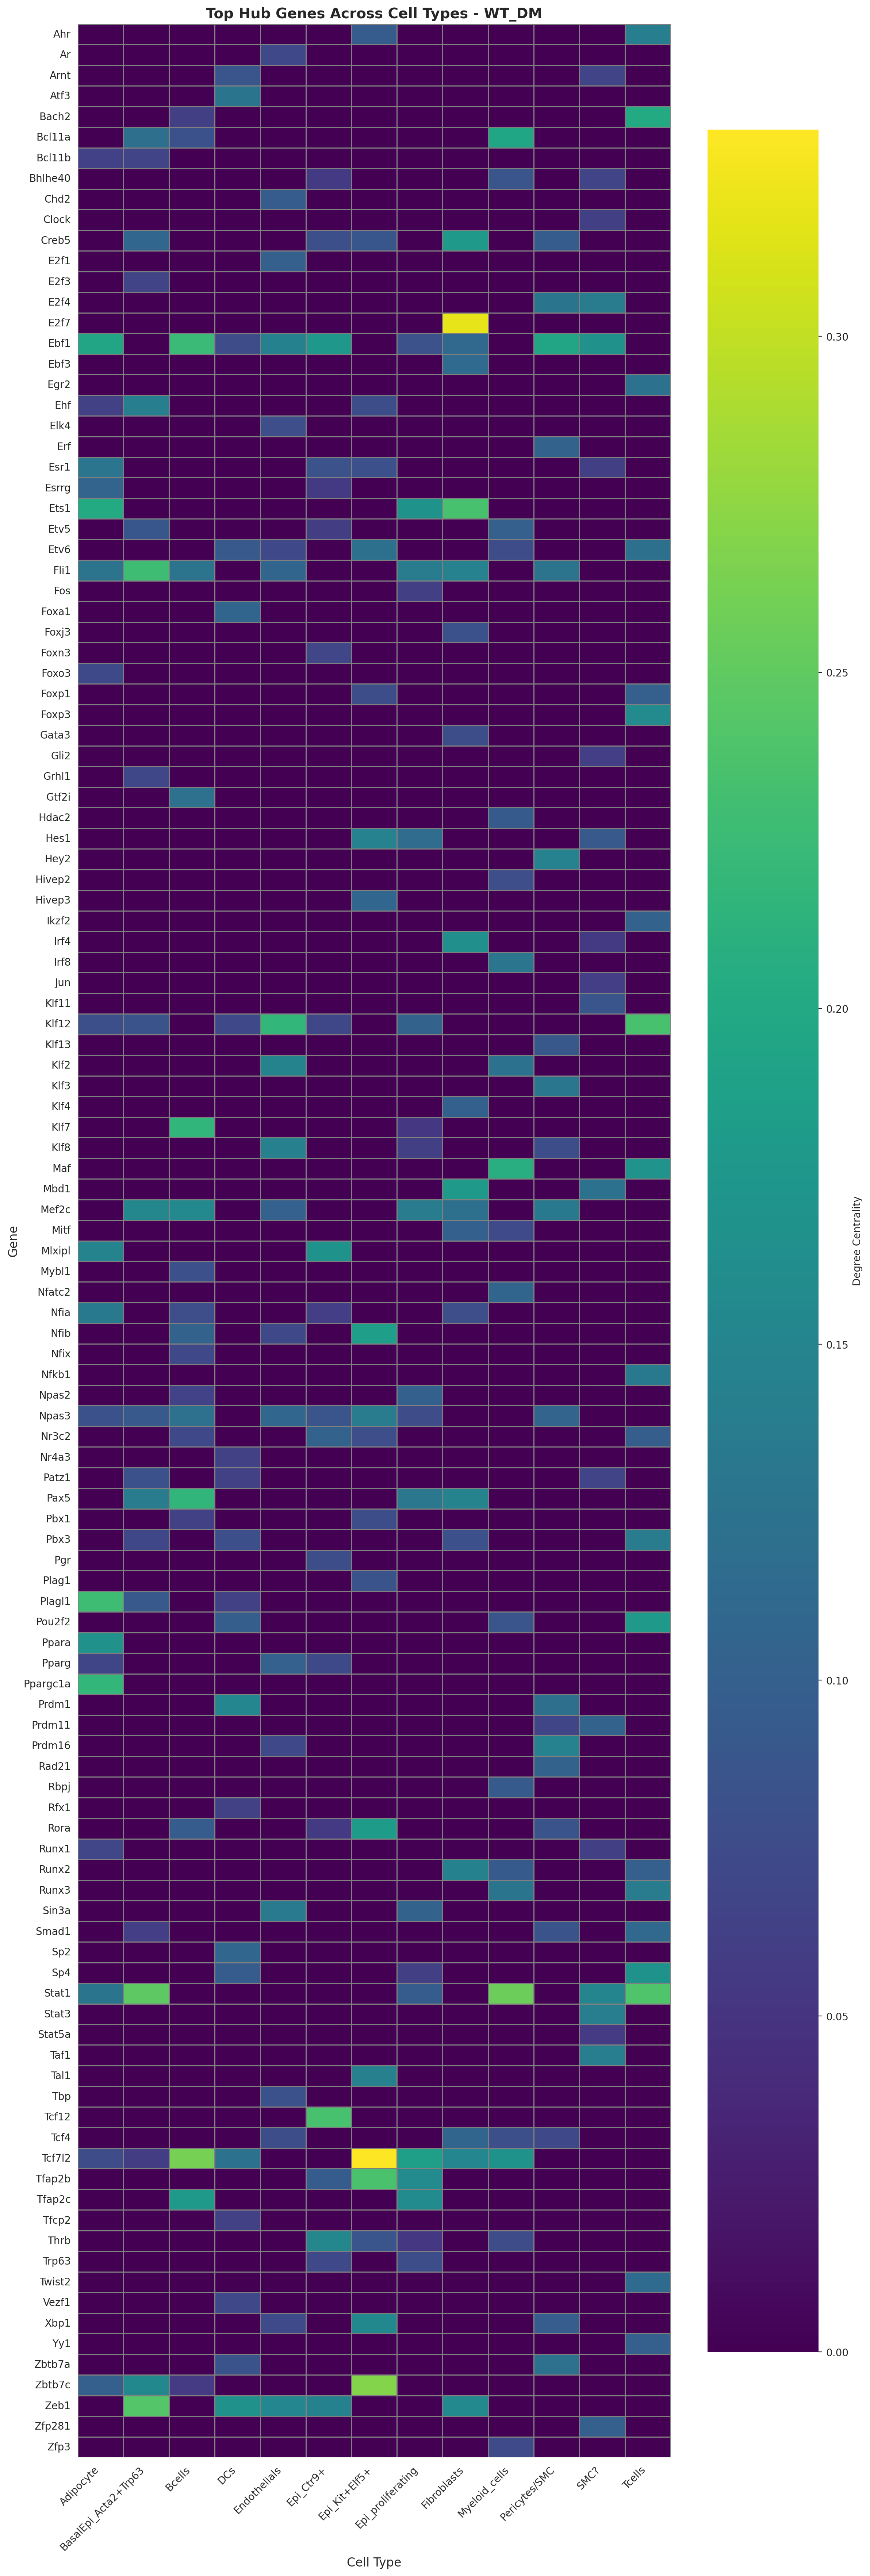

✓ Cross-cell-type heatmap saved for WT_DM


In [21]:
# Heatmap: top hub genes across cell types (for a specific sample)
if all_summaries:
    # Get unique samples
    samples = summary_df['sample'].unique()
    
    for sample_name in samples:
        sample_data = summary_df[summary_df['sample'] == sample_name]
        pivot = sample_data.pivot_table(
            index='gene', columns='cell_type',
            values='degree_centrality_all', aggfunc='first'
        )
        
        plt.figure(figsize=(12, max(8, len(pivot) * 0.3)))
        sns.heatmap(pivot.fillna(0), cmap='viridis',
                    cbar_kws={'label': 'Degree Centrality'},
                    linewidths=0.5, linecolor='gray')
        plt.title(f'Top Hub Genes Across Cell Types - {sample_name}',
                  fontsize=14, fontweight='bold')
        plt.xlabel('Cell Type', fontsize=12)
        plt.ylabel('Gene', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        safe_sample = sample_name.replace("/", "_")
        plt.savefig(f"{base_figures}/cross_celltype_heatmap_{safe_sample}.png",
                    dpi=300, bbox_inches='tight')
        plt.show()
        print(f"\u2713 Cross-cell-type heatmap saved for {sample_name}")